# Introduction to VIDA

## Installation
VIDA is written in the Julia programming language for a few reasons:
 1. It is fast! Julia can achieve C and Fortan speeds while not having to deal with memory.
 2. It's syntax is very simple. Unlike Themis which is written in C++ the development time is orders of magnitude lower in Julia.
 3. I wanted to write a Julia package...
 
So to install VIDA you first have to install the Julia binary on your system. The best bet is to go to the Julia site and install the official [binary](https://julialang.org/downloads/)

To install the VIDA package you can run the following

In [ ]:
using Pkg; Pkg.add(PackageSpec(url="https://github.com/ptiede/VIDA.jl.git"))

This will install VIDA into your local environment and pull all the dependencies. Note however, that the dependencies defined in this package will not be installed into your main Julia environment. To add those you will have to install them. For example if you want to install PyPlot, and/or DataFrames (basically Pandas for Julia) you can do

In [ ]:
Pkg.add("DataFrames");

# Idea behind VIDA
`VIDA` is based on the idea of intrepreting the image as a probility distribution. Namely since any image is integrable, the space of images is in one-to-one correspondence with a probability distribution, especially since the total flux of the image is already known a priori.

Therefore, our idea is very close to variational inference, hence the name *Variational Image Domain Analysis*. Namely, where we view the image as a distribution and we aim to find a approximation of the distribution given some parameteric family $f_\theta(x,y)$, which for our purproses we will typically call a *filter*. 

The choice of filter, depends on the problem of interest, namely what features we are interested in. Typically for the EHT where our images tend to be rings, we are interested in

 - Radius r₀
 - Width or half width σ
 - Structural asymmetry τ
 - Flux asymmetry s
 - Position angle ξ

`VIDA` then defines a series of filters parameterize these features.

## filters
Currently we have 5 filters defined, although they all belong to the same family. For an example on how to see the process for defining your own filter please see the [readme](https://github.com/ptiede/VIDA.jl/blob/master/README.md).

The filters implemented are:

 - `GaussianRing` which is a symmetric and circular Gaussian ring.
 - `SlashedGaussianRing` which is a circular Gaussian ring with a flux gradient across its emission.
 - `EllipticalGaussianRing` symmetric Gaussian elliptical ring, where the emission is constant across the ring, unlike with the SlashedGaussianRing.
 - `GeneralGaussianRing` A combination of the two above where the ring is allowed to be elliptical and have a intensity gradient.
 - `TIDAGaussianRing` The GeneralGaussianRing, but where the asymmetry and flux orienation are fixed relative to one another.
 - `AsymGaussian` A asymmetric Gaussian blob. This can be useful if you image has a strong non-ring component in it.
 - `Constant` Adds a constant flux floor to the image. This is very helpful for image reconstructions that tend to add small scale flux everywhere in the image.

## Divergences
In order to extract features we first need a cost function that penalized our parameterized distributions $f_\theta(x,y)$. Since we are considering the image as a probability distribution, one cost function would be the distance or **divergence** between two distributions. A probability divergence is just a functional that takes in two probability distributions p,q and is minimized iff $p\equiv q$.

Currently we have two divergences implemented in `VIDA`
 - Bhattacharyya divergence (Bh)
$$
 Bh(f_\theta|I) = \int \sqrt{f_\theta(x,y)I(x,y)} dxdy.
$$
 - KL divergence 
$$
 KL(f_\theta|I) = \int f_\theta(x,y)\log\left(\frac{f_\theta(x,y)}{I(x,y)}\right)dxdy. 
$$
Both divergences give very similar answers, although we found the BH to be easier to maximize.


## Using `VIDA`
Using VIDA is based on constructing three items:
 1. Data, i.e. an image that you want to extract features from.
 2. Cost function, i.e. pick if you want to use the KL or BH divergence 
 3. Filter, i.e. construct the family of distributions or filters that you will use to approximate the image.
Then all you need to do is minimize the divergence and you will have extracted you image features.

Now lets runs through how that works



### Step 1 Read in Data
`VIDA` currently only works with fits images. THe fits header is based off of what [eht-imaging](https://github.com/achael/eht-imaging) outputs. So as long as you stick to that standard you should be fine.

To read in an image we just use the `load_ehtimfits` function


In [2]:
#Load the packages into your current environment
using VIDA

┌ Info: Precompiling VIDA [4096cdfb-f084-40a3-b02d-1a2a54920cb8]
└ @ Base loading.jl:1260


In [5]:
#Load the image
img = load_ehtimfits("elliptical_gaussian_rot-45.00m87Scale_seed_23_simobs_netcal_scanavg-z0.6-s100-t0-v0-l0-p50-e0.000.fits")
println("Loaded image")
#To plot the image we can just call plot. This uses recipes and the Plots.jl framework
plot(img)


/tmp/6a483cbe-902d-44fb-b3ab-a68d7c281285

ErrorException: While processing file `elliptical_gaussian_rot-45.00m87Scale_seed_23_simobs_netcal_scanavg-z0.6-s100-t0-v0-l0-p50-e0.000.fits`: could not open the named file

Julia isn't a traditional OOP language. Namely, methods/functions are first class and aren't members of a class. Instead how a function behaves is dependent on the type of argument inputs. This is known as something called multimethods or *multiple dispatch* where at run-time the type of functions called is determined by the arguments. 

In some sense OOP is just a multiple dispatch type language where the our type of dispatch only depends on the class, i.e. the self argument in Python classes. 



In [3]:
#To see what functions can act on an EHTImage object just call
methodswith(EHTImage)

[1] clipimage(clip, im::EHTImage) in VIDA at /home/ptiede/.julia/packages/VIDA/WGQcM/src/images.jl:55
[2] clipimage(clip, im::EHTImage, mode) in VIDA at /home/ptiede/.julia/packages/VIDA/WGQcM/src/images.jl:55
[3] make_div(image::T, div_type) where T<:EHTImage in VIDA at /home/ptiede/.julia/packages/VIDA/WGQcM/src/divergences.jl:12
[4] make_div(image::T, div_type, lreg) where T<:EHTImage in VIDA at /home/ptiede/.julia/packages/VIDA/WGQcM/src/divergences.jl:12
[5] save_ehtimfits(image::EHTImage, fname::String) in VIDA at /home/ptiede/.julia/packages/VIDA/WGQcM/src/images.jl:188

## Step 2 Create the Divergence
The next step to getting `VIDA` to run is to define a divergence. This is done with the `make_div` function, which is actually a closure, and returns the divergence function depending on the image we are trying to extract features from

In [4]:
#Make the Bh divergence
bh = BhattaCharyya(img)
#Make the KL divergence
kl = KullbackLeibler(img)

#29 (generic function with 1 method)

## Step 3 Create our Filter
Next we need to decide the filter we will be using. I'll show how to use every filter we have defined

To see the documentation for how to create a filter just type

In [ ]:
?GaussianRing

In [ ]:
?SlashedGaussianRing

In [ ]:
?EllipticalGaussianRing

In [ ]:
?TIDAGaussianRing

In [51]:
?GeneralGaussianRing

search: GeneralGaussianRing



```julia
struct GeneralGaussianRing <: VIDA.AbstractFilter
```

Creates the most general elliptical slashed gaussian ring model. It is a combination of the elliptical and slashed gaussian ring. The direction of the slash and the ellipticity are not aligned or anti-aligned like with the TIDAGaussianRing type.

### Details

Adds ellipticity to the ring. The radius `r0` of the ring is now defined as the geometric mean of the semi-major (a) and semi-minor (b) axis lengths i.e.

r0 = √(a*b).

The ellipticity `τ` is given by τ = 1-b/a.

### Fields

  * `r0`

    Radius of the Gaussian ring
  * `σ`

    Standard deviation of the width of the Gaussian ring
  * `τ`

    Asymmetry of the Gaussian ring defined as $1-b/a$
  * `ξτ`

    Asymmetry orientation in radians, measured north of east
  * `s`

    Slash of Gaussian ring.
  * `ξs`

    Slash orientation in radians measured north of east
  * `x0`

    x position of the center of the ring in μas
  * `y0`

    y position of the center of the ring in μas


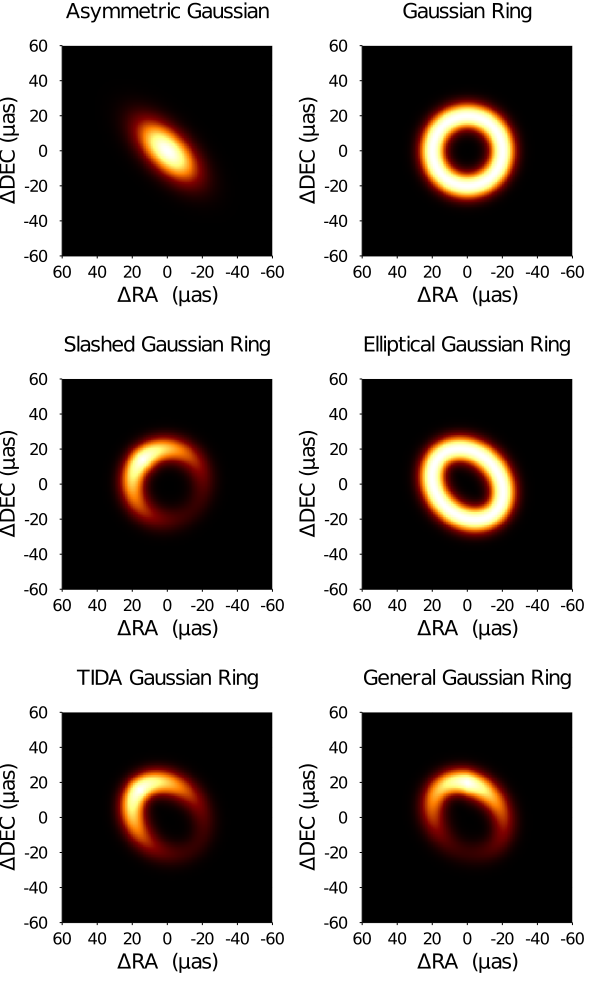

In [5]:
#Note Julia uses unicode for characters.
#To create a variable θ type \theta then hit tab.
#In general the LaTeX command + tab will autocomplete to 
#The correct character
using Plots
layout = @layout [a b;
                  c d;
                  e f]
θg = AsymGaussian(10.0,0.5,π/4, 0.0,0.0)
a = plot(θg)
title!("Asymmetric Gaussian")

θgr = GaussianRing(20.0,5.0,0,0)
#Again to plot the filter just do
b = plot(θgr)
title!("Gaussian Ring")


#For the SlashedGaussianRing type
#Note that we can directly refer to the parameter names so we can actually name the
#parameters in any order
θsgr = SlashedGaussianRing(r0=20.0, σ=5.0, s=0.9, ξ=π/4, x0=0.0, y0 = 0.0)
c = plot(θsgr)
title!("Slashed Gaussian Ring")

θell = EllipticalGaussianRing(r0=20.0, σ=5.0, τ=0.2, ξ=π/4, x0=0.0, y0 =0.0)
d = plot(θell)
title!("Elliptical Gaussian Ring")

#For the TIDAGaussianRing we just use
θtgr = TIDAGaussianRing(r0=20.0, σ=5.0, τ=0.2, ξ=π/4, s=0.9, x0=0.0, y0 = 0.0)
e = plot(θtgr)
title!("TIDA Gaussian Ring")


#For the GeneralGaussianRing we just use
θggr = GeneralGaussianRing(r0=20.0, σ=5.0, τ=0.2, ξτ=π/4, s=0.9, ξs=π/2, x0=0.0, y0 = 0.0)
f = plot(θggr)
title!("General Gaussian Ring")


#Create a subplot
plot(a,b,c,d,e,f, layout = layout, size=(600,1000))

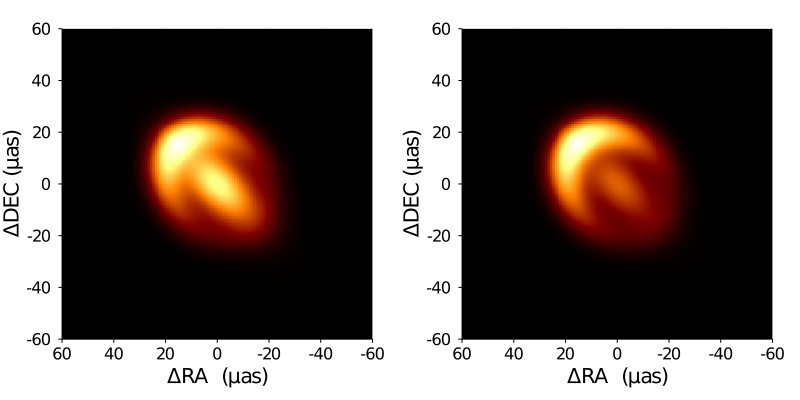

In [6]:
#If you want to stack filters you can use the stack function
θs = cat(θg, θtgr)
a = plot(θs)
#Or you can even just add them and multiply by a factor!
θs = θtgr + 0.5*θg
b = plot(θs)
plot(a,b, size=(800,400))

Hopefully you find that interface pretty easy to use. Now if you want to fit our image you need to call the `extract` or `bbextract` functions. `extract` uses Optim.jl as its backend and has a bunch of different optimizers to choose from. By default we use a LBFGS, i.e. a gradient solver, but this tends to get stuck in a lot of local minima. Optim.jl also has a simulated annealing solver called SAMIN() and that is our recommended solver.

However, in general as a first pass we suggest just using the `bbextract` functions. This tends be a lot better at finding the global maxima of our problem in a single pass. To use bbextract you can pull up the documentation

In [ ]:
?bbextract

In [ ]:
?extract

To use bbextract we need to define an initial position. This will also change the type of filter to use. From our img we see that if looks like a slashed elliptical ring, so we will use the GeneralGaussianRing as our filter.

In [7]:
#First define the parameters bounds
lbounds = [5.0, 0.01, 0.001, 0, 0.001, -π, -80.0, -80.0]
ubounds = [60.0, 40.0, 0.999, π, 0.999, π, 80.0, 80.0]



8-element Array{Float64,1}:
 60.0              
 40.0              
  0.999            
  3.141592653589793
  0.999            
  3.141592653589793
 80.0              
 80.0              

In [8]:
#Now extract!
results = bbextract(bh, θggr, lbounds, ubounds; TraceMode=:compact)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 366 evals, 272 steps, improv/step: 0.375 (last = 0.3750), fitness=0.272612051
1.00 secs, 774 evals, 667 steps, improv/step: 0.297 (last = 0.2430), fitness=0.234286622
1.50 secs, 1238 evals, 1125 steps, improv/step: 0.242 (last = 0.1616), fitness=0.219043388
2.00 secs, 1693 evals, 1570 steps, improv/step: 0.220 (last = 0.1663), fitness=0.208394210
2.50 secs, 2131 evals, 2008 steps, improv/step: 0.207 (last = 0.1598), fitness=0.197787123
3.00 secs, 2566 evals, 2444 steps, improv/step: 0.199 (last = 0.1606), fitness=0.185478322
3.50 secs, 3001 evals, 2879 steps, improv/step: 0.188 (last = 0.1287), fitness=0.180522495
4.00 secs, 3435 evals, 3313 steps, improv/step: 0.188 (last = 0.1866), fitness=0.177674768
4.51 

(GeneralGaussianRing
  r0: Float64 19.270070562271286
  σ: Float64 3.8239107951573237
  τ: Float64 0.22701050591931737
  ξτ: Float64 1.1696212636214967
  s: Float64 0.7248628129490928
  ξs: Float64 0.7195128232442405
  x0: Float64 -6.483961763173045
  y0: Float64 -3.946300338921937
, 0.12677748760797944, false, 20000)

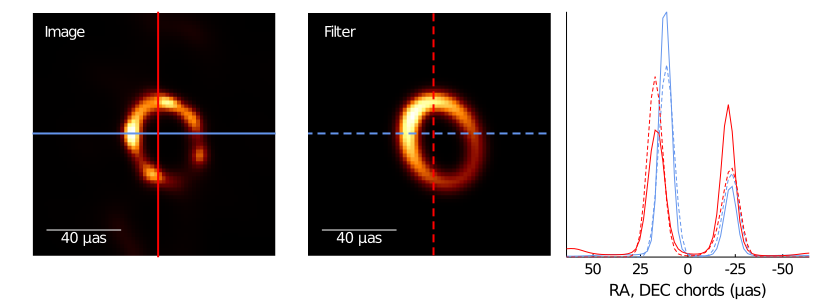

In [9]:
#Lets plot the results
triptic(img, results[1])

Well that looks atrocius! What happened? Well from the fit we can see that the filter decided that there was a bunch of lower level flux throughout the image and the best fit was to just soak up as much as that as possible.

This provides a hint for how to fix this. We should probably add a low level flux to our image. To do that we just do

In [10]:
θinit = θggr + 1.0*Constant()
#Define the new bounds were we just append the additional
#parameter for the intensity level for the constant
lbounds2 = [lbounds...,1e-6]
ubounds2 = [ubounds...,1e3]
results = bbextract(bh, θinit, lbounds2, ubounds2)

(VIDA.AddFilter{GeneralGaussianRing,VIDA.MulFilter{Float64,Constant}}(GeneralGaussianRing
  r0: Float64 19.1708140389497
  σ: Float64 3.282540252789197
  τ: Float64 0.21364252799559177
  ξτ: Float64 1.1760044408915948
  s: Float64 0.7447197350737196
  ξs: Float64 0.7141051461744246
  x0: Float64 -6.390323926104122
  y0: Float64 -3.728921466543451
, VIDA.MulFilter{Float64,Constant}(0.009824109060902394, Constant())), 0.02402927739172276, false, 20000)

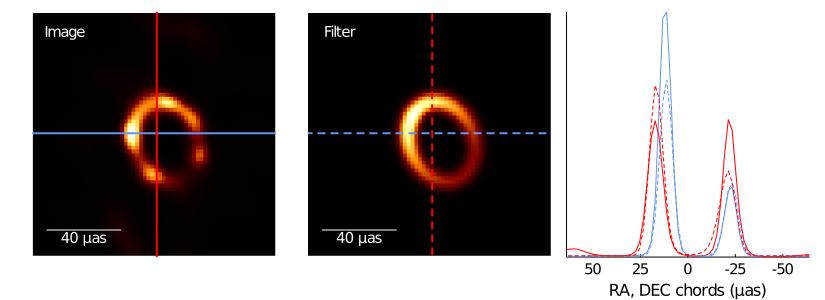

In [11]:
#Plot the comparisson between the image and filter
triptic(img,results[1])

Well that's much much better! **In general you should always add a floor to your filter**.

#### Image 2
Lets now look at another image that is a little harder to fit.

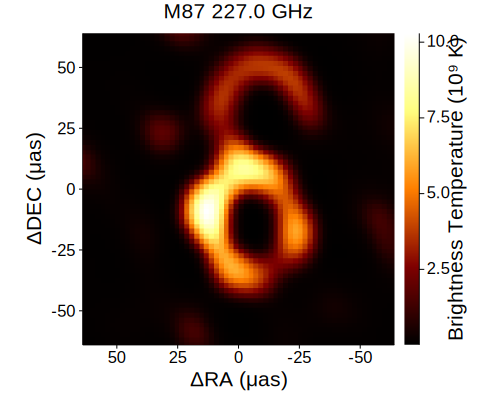

In [12]:
img2 = load_ehtimfits("elliptical_gaussian_rot-45.00m87Scale_seed_23_simobs_netcal_scanavg-z0.6-s100-t1-v100-l10-p40-e0.000.fits")
plot(img2)

This one is a little more interesting since it waffled a bit and so there is a second ring.
Lets see how we do when we fit a single ring with a floor.

In [13]:
bh2 = make_div(img2,:Bh)

#27 (generic function with 1 method)

In [14]:
results2 = bbextract(bh2, θinit, lbounds2, ubounds2)

(VIDA.AddFilter{GeneralGaussianRing,VIDA.MulFilter{Float64,Constant}}(GeneralGaussianRing
  r0: Float64 19.069658565082722
  σ: Float64 5.000388072426024
  τ: Float64 0.23588499155401996
  ξτ: Float64 1.335893226848686
  s: Float64 0.6829514629902591
  ξs: Float64 0.5450774542873689
  x0: Float64 -4.9980897793744585
  y0: Float64 -12.8774211651264
, VIDA.MulFilter{Float64,Constant}(0.02110608426934225, Constant())), 0.0787624695529358, false, 20000)

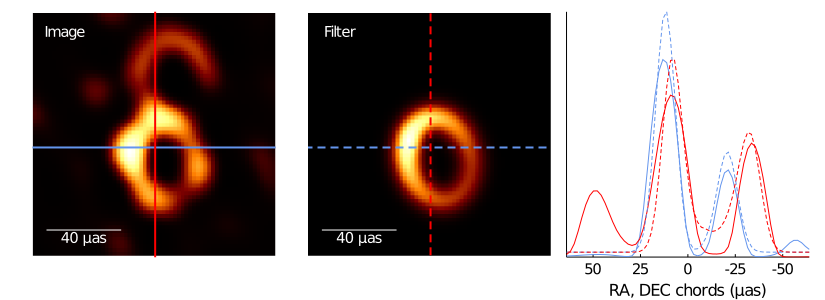

In [15]:
triptic(img2, results2[1])

Wow! It managed to completely ignore the second ring! This is actually pretty neat and wasn't expected when I first ran it. It simply relfects that the second ring has much less flux than the other so the filter can just increase the floor to eat up some of that second ring

An interesting question is if we add another ring, can we recover that too. Let's try!

In [16]:
#Update the filter and the bounds to reflect the additional ring
θinit3 = θggr + 1.0*Constant() + 1.0*θggr 
lbounds3 = [lbounds2..., lbounds..., 1e-6]
ubounds3 = [ubounds2..., ubounds..., 1e3];

In [17]:
results3 = bbextract(bh2, θinit3, lbounds3, ubounds3; MaxFuncEvals=75000, TraceMode=:compact)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 217 evals, 138 steps, improv/step: 0.362 (last = 0.3623), fitness=0.250438328
1.00 secs, 428 evals, 322 steps, improv/step: 0.351 (last = 0.3424), fitness=0.228913297
1.51 secs, 643 evals, 534 steps, improv/step: 0.300 (last = 0.2217), fitness=0.179986571
2.01 secs, 856 evals, 747 steps, improv/step: 0.278 (last = 0.2254), fitness=0.177848837
2.51 secs, 1071 evals, 962 steps, improv/step: 0.271 (last = 0.2465), fitness=0.177848837
3.01 secs, 1281 evals, 1172 steps, improv/step: 0.256 (last = 0.1857), fitness=0.177848837
3.51 secs, 1491 evals, 1382 steps, improv/step: 0.247 (last = 0.2000), fitness=0.165173142
4.01 secs, 1704 evals, 1595 steps, improv/step: 0.238 (last = 0.1737), fitness=0.156950686
4.51 secs,

43.60 secs, 18207 evals, 18101 steps, improv/step: 0.186 (last = 0.1415), fitness=0.048418110
44.10 secs, 18407 evals, 18301 steps, improv/step: 0.186 (last = 0.1850), fitness=0.048418110
44.60 secs, 18609 evals, 18503 steps, improv/step: 0.186 (last = 0.1584), fitness=0.048418110
45.11 secs, 18812 evals, 18706 steps, improv/step: 0.186 (last = 0.1478), fitness=0.048418110
45.61 secs, 19014 evals, 18908 steps, improv/step: 0.185 (last = 0.1238), fitness=0.048418110
46.11 secs, 19212 evals, 19106 steps, improv/step: 0.184 (last = 0.1061), fitness=0.048418110
46.61 secs, 19420 evals, 19314 steps, improv/step: 0.184 (last = 0.1587), fitness=0.048340783
47.11 secs, 19625 evals, 19519 steps, improv/step: 0.183 (last = 0.1415), fitness=0.048061399
47.61 secs, 19829 evals, 19723 steps, improv/step: 0.183 (last = 0.1961), fitness=0.045338049
48.11 secs, 20036 evals, 19930 steps, improv/step: 0.183 (last = 0.1353), fitness=0.045338049
48.61 secs, 20244 evals, 20138 steps, improv/step: 0.183 (la

130.81 secs, 55245 evals, 55142 steps, improv/step: 0.185 (last = 0.1697), fitness=0.025877240
131.31 secs, 55458 evals, 55355 steps, improv/step: 0.185 (last = 0.1455), fitness=0.025877222
131.81 secs, 55673 evals, 55570 steps, improv/step: 0.185 (last = 0.1349), fitness=0.025877222
132.31 secs, 55888 evals, 55785 steps, improv/step: 0.184 (last = 0.1674), fitness=0.025877187
132.81 secs, 56100 evals, 55997 steps, improv/step: 0.184 (last = 0.1887), fitness=0.025877152
133.31 secs, 56316 evals, 56213 steps, improv/step: 0.185 (last = 0.2500), fitness=0.025877141
133.81 secs, 56533 evals, 56430 steps, improv/step: 0.185 (last = 0.1613), fitness=0.025877141
134.31 secs, 56750 evals, 56647 steps, improv/step: 0.185 (last = 0.1751), fitness=0.025877116
134.82 secs, 56967 evals, 56864 steps, improv/step: 0.185 (last = 0.1705), fitness=0.025877116
135.32 secs, 57178 evals, 57075 steps, improv/step: 0.184 (last = 0.1611), fitness=0.025877116
135.82 secs, 57398 evals, 57295 steps, improv/step

(VIDA.AddFilter{VIDA.AddFilter{GeneralGaussianRing,VIDA.MulFilter{Float64,Constant}},VIDA.MulFilter{Float64,GeneralGaussianRing}}(VIDA.AddFilter{GeneralGaussianRing,VIDA.MulFilter{Float64,Constant}}(GeneralGaussianRing
  r0: Float64 22.393531666095182
  σ: Float64 4.52715391660839
  τ: Float64 0.32302394601859163
  ξτ: Float64 1.204111462626278
  s: Float64 0.9989999994037944
  ξs: Float64 1.0623040558040528
  x0: Float64 -12.859257633088712
  y0: Float64 24.307589020235966
, VIDA.MulFilter{Float64,Constant}(0.02599179726132435, Constant())), VIDA.MulFilter{Float64,GeneralGaussianRing}(2.127055924633768, GeneralGaussianRing
  r0: Float64 19.049690015977507
  σ: Float64 4.992486861288794
  τ: Float64 0.2077222501882894
  ξτ: Float64 1.333250302679118
  s: Float64 0.6636754063978831
  ξs: Float64 0.48853266977634874
  x0: Float64 -5.11976806654998
  y0: Float64 -13.173374295097267
)), 0.025877024506532325, false, 20000)

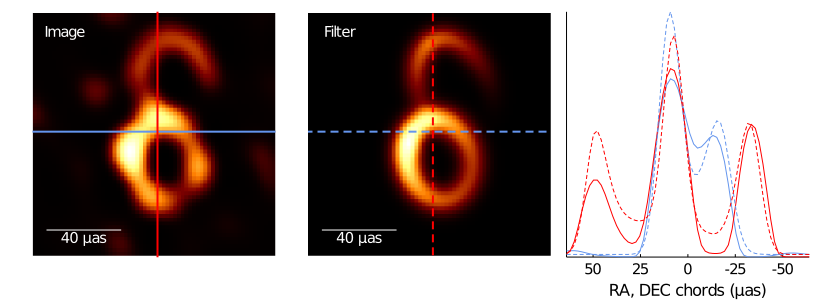

In [18]:
triptic(img2, results3[1])

In [19]:
#If you want to individually compare two components you can use the split function
θ3comp = split(results3[1])

3-element Array{VIDA.AbstractFilter,1}:
 GeneralGaussianRing
  r0: Float64 22.393531666095182
  σ: Float64 4.52715391660839
  τ: Float64 0.32302394601859163
  ξτ: Float64 1.204111462626278
  s: Float64 0.9989999994037944
  ξs: Float64 1.0623040558040528
  x0: Float64 -12.859257633088712
  y0: Float64 24.307589020235966
                                                                
 VIDA.MulFilter{Float64,Constant}(0.02599179726132435, Constant())                                                                                                                                                                                                                                                                                       
 VIDA.MulFilter{Float64,GeneralGaussianRing}(2.127055924633768, GeneralGaussianRing
  r0: Float64 19.049690015977507
  σ: Float64 4.992486861288794
  τ: Float64 0.2077222501882894
  ξτ: Float64 1.333250302679118
  s: Float64 0.6636754063978831
  ξs: Float64 0.48853266

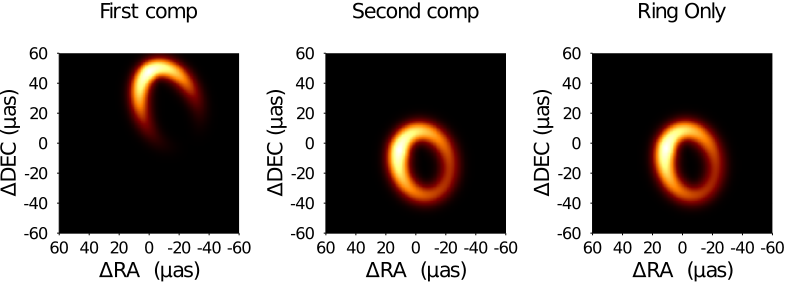

In [20]:
#Now lets plot each component
comp = map(x->plot(x),θ3comp)
layout = @layout [a b c]

plot(plot(comp[1],title="First comp"), plot(comp[3], title="Second comp"), plot(results2[1], title="Ring Only"), layout = layout, size=(800,300))


Isn't that neat! It found the other crescent! And the first crescent didn't even move!

### Distributing the workload
At this point you hopefully get the idea on how to use `VIDA`. However, there are some more advanced features. `VIDA` is threadsafe and can work on a distributed environment. An example of how to use `VIDA` with Julia's native parallel computing package `Distributed` is given in `examples/bbimage_extractor.jl` which required ArgParse to work

#### Using extract and threads
However, if you want to use a a threaded version of `VIDA` the extract function natively works with threads. To see this we refer to the help

In [71]:
?extract

search: extract bbextract extrema



```julia
extract(nstart, divergence, θinit, lbounds, ubounds, args; kwargs...)

```

Function that uses Optim.jl to minimize our divergence to extract the image features. `divergence` is our cost function to be optimized that is formed from make_bh. `θinit`, is the initial filter to use and must be a subtype of AbstractFilter. `lbounds` and `ubounds` are the upper and lower bounds of the problem. `method` is the maximization algorithm to use. For a list of availible methos see the Optim.jl package, as well as for the other various args, and kwargs that can be passed.

# Notes

`lbounds` and `ubounds` will actually be evaluated, namely they must be included in the mode they form the closed hypercube of parameter space.

This is also the threaded version of the code. If you want to just run a single case don't pass nstart.

Also most of the filters aren't autodiffable right now so be careful with the autodiff feature.

---

This is the single threaded version of extract. By default we use simulated annealing for the maximization, since other than the BlackBoxOptim drivers it tends to find the global max unlike some of the local methods.


Here we see that the call `extract(n::Int, divergence, lower, upper)` is natively threaded. Namely, it will run `n` independent instances of extract, with different starting locations. This can help with convergence, especially if you use the default LBFGS method. 

To launch julia with more than 1 thread, in your terminal first type 
`export JULIA_NUM_THREADS = number of threads`
For example on my machine I have 4 threads. Then you just need to launch julia. To check if it has worked type:

In [21]:
println(Threads.nthreads())

4


Great! So now I have 4 threads to work with. Lets now try to run extract using 1 core and then 4.

In [49]:
@time extract(1,bh2,θinit3, lbounds3, ubounds3)

Extractor failed for initializer:
[48.36021239040907, 37.5735573211014, 0.5158341595765663, 2.966207508477577, 0.9956237122301589, -0.48009071316183816, 46.675518091674846, -63.72885905037425, 608.7757965433474, 5.056757932247738, 34.32487576758697, 0.018783367706527984, 0.8532137432802585, 0.20197688377566067, 3.1284104458209194, -68.67682049447559, -74.45632892036843, 783.5046463314413]


MethodError(Optim.optimize, (VIDA.var"#f#44"{VIDA.AddFilter{VIDA.AddFilter{GeneralGaussianRing,VIDA.MulFilter{Float64,Constant}},VIDA.MulFilter{Float64,GeneralGaussianRing}},VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}}(VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}(EHTImage{Array{Float64,2}}(64, 64, -1.99999999999998, 1.9999999999999982, "M87", 187.7059307575226, 12.39112323919932, 0.0013202604029237865, 57854.02228009328, [6.606297374817375e-6 7.0235017946615515e-6 7.793229217885635e-6 8.87470119706653e-6 1.0248196505134434e-5 1.1843792448589296e-5 1.3486734396634213e-5 1.4890450837385292e-5 1.5728288603967197e-5 1.5776219695627338e-5 1.504014859926923e-5 1.3765603284683692e-5 1.2323765876328066e-5 1.107388542684893e-5 1.0306122698968396e-5 1.0309614630138416e-5 1.1631651724506867e-5 1.5807809502437843e-5 2.6606128740077175e-5 4.898704550997095e-5 8.217887629459041e-5 0.000

e-6 7.749424210416484e-6 1.0291489065019619e-5 1.5511604797781366e-5 2.727856978756866e-5 5.181898321687956e-5 9.0967234397818e-5 0.00013380506895282888 0.00016151066459496534 0.00016262019869568803 0.0001494561234231937; 9.311760016643715e-6 8.900046073155168e-6 8.528263465124002e-6 8.53570242414472e-6 9.04855480804397e-6 1.0192091417264617e-5 1.2216955839647188e-5 1.558332537437419e-5 2.100827653391984e-5 2.9219575765350957e-5 3.990167512420689e-5 5.013857919082201e-5 5.490113838295245e-5 5.0958655426405975e-5 4.001356767772038e-5 2.714599624448433e-5 1.6767383180677953e-5 1.0499684638907326e-5 9.345471952715711e-6 2.156010675883977e-5 7.443149332492542e-5 0.00020694453159380476 0.0004219267385545363 0.0006696926907588431 0.0008976614003477528 0.0010645889920502176 0.0011372639319564269 0.001097416144848657 0.0009457764033670566 0.0007024036198925389 0.0004128457382014048 0.0001673475963233861 4.226408687610811e-5 7.816586306415748e-6 2.3150074156214666e-6 2.170431101196542e-6 6.3266

e-5 1.174509754476658e-5 9.433854269467288e-6 7.645906077960639e-6 6.893964092357681e-6 1.0824786532143755e-5 3.8441335797092586e-5 0.0001364678692186327 0.0003409529721015614 0.0006220249182587086 0.0009152674626775097 0.0011690734543784512 0.0013524384286338008 0.0014483756578213655 0.0014464311872793858 0.0013474189540252902 0.0011644524296286654 0.0009177034594238316 0.0006384413458536263 0.0003758477290016104 0.00018507632958803292 8.817445898099319e-5 6.615622673906396e-5 8.766789265872213e-5 0.00014054714740490196 0.000233819253368456 0.00036135289221045 0.0004941433974768317 0.0005980405275722384 0.0006463898603260944 0.0006240305660578332 0.0005312507442425422 0.00038808849734465014 0.00023280534804123246 0.00010888910248291699 3.84945550018683e-5 1.2047209824128394e-5 6.326722333729447e-6 6.453432616758067e-6 8.210086205574222e-6 1.123140083203535e-5 1.5987054141814602e-5 2.3351776103676128e-5 3.450357527006706e-5 5.025552981448891e-5 6.93530191964337e-5 8.696625377034266e-5 

-5 1.827153372328232e-5 1.834682346936986e-5; 0.0001904202149107899 0.0001596983900627736 0.00011473218609527993 7.418744537963291e-5 4.630717086052472e-5 2.9795200461090885e-5 2.0594654583423855e-5 1.551810125427004e-5 1.2717684014006294e-5 1.1228536534145227e-5 1.0572938545412737e-5 1.0544559127432595e-5 1.1079170247115406e-5 1.2155245580306292e-5 1.3661584029107556e-5 1.5219132916966133e-5 1.616886138371029e-5 1.5937733572402e-5 1.4507999760921163e-5 1.2489415991330242e-5 1.0925560058641986e-5 1.1883094024521765e-5 2.013134538144068e-5 4.471934961131214e-5 0.00010586600145506191 0.0002334882883761808 0.00042730047293506007 0.0006403829206804246 0.0008322293217489971 0.0009930132255267573 0.0011178574405202963 0.001200529051890449 0.001240898713163592 0.0012448346304113809 0.001218173206895947 0.0011644371004857657 0.0010866867315700553 0.000985621621024597 0.0008604374176362716 0.0007130185769225767 0.0005486882315642778 0.00037792693184072324 0.00022060277446569315 0.00010249729951

6.3691428471573e-5 4.297192591292052e-5 4.6821979016284075e-5 7.99021060603609e-5 0.0001469912525649985 0.00023656333527679587 0.0003250733781788097 0.0003924495897834481 0.00042201342318876604 0.0004021613570413661 0.00033193469827717267 0.0002276599956949396 0.00012364688925233712 5.102397151486526e-5 1.627090258801024e-5 5.065890143269224e-6 2.484610519549736e-6 2.195842982124467e-6 2.7717979053082715e-6 4.231182013590264e-6 7.534223599757426e-6 1.543028925663673e-5 3.238324031034095e-5 5.911011304027332e-5 8.660435736827286e-5 0.00010188172722562454 9.89601896192406e-5 8.184020833539385e-5 5.9809800280710755e-5 4.105373261949648e-5 2.8844346598684117e-5 2.217936159374959e-5 1.886609747542862e-5 1.7406253945210633e-5 1.710714836686858e-5 1.7739047879389168e-5 1.933908349143488e-5 2.214471112519316e-5 2.6539098333081377e-5 3.280549792226918e-5 4.024468272835455e-5 4.625284567685221e-5 4.8776840095184155e-5; 2.048075023550192e-5 1.7354574794142604e-5 1.3720645506069516e-5 1.1220625625

44094154838929993 0.0004930419485170989 0.0004833246302028642 0.0004150422441999645 0.00030470321208426717 0.00018259791933711284 8.586571505103812e-5 3.3549750401988154e-5 1.4458317196807689e-5 9.405585963787378e-6 8.508649422325563e-6 8.945294118487889e-6 1.010097270395849e-5 1.1813036061388349e-5 1.3985238036548882e-5 1.6481513816847e-5 1.9055123601106438e-5 2.129693829704467e-5 2.264538742621411e-5 2.2671406878866496e-5 2.1966902605600202e-5; 1.0604794107628523e-5 1.0332760831862564e-5 1.0119144362237614e-5 1.0210999171873781e-5 1.0671602804163583e-5 1.1488869764743706e-5 1.2607498190084363e-5 1.390948038381394e-5 1.5196692180454384e-5 1.621021922891149e-5 1.669828402827995e-5 1.6505777969284837e-5 1.5634700090067766e-5 1.4239427309027457e-5 1.2563271470104109e-5 1.0859047231868965e-5 9.334209590292535e-6 8.133637295754192e-6 7.356578648111038e-6 7.109800199738598e-6 7.66682291375522e-6 1.0352306414895646e-5 2.186585928206216e-5 6.088241767143154e-5 0.0001448591528699739 0.00026249

22413632561651e-6 8.31806297650353e-6 8.518988021670157e-6 8.785302906427891e-6 9.062611660985972e-6 9.29184422853578e-6 9.423290557736563e-6 9.432575551791004e-6 9.331096745309966e-6 9.166560219111935e-6 9.0140371311349e-6 8.96171912721962e-6 9.102303637686089e-6 9.536946375510254e-6 1.0380341666984754e-5 1.1730315960864752e-5 1.3572169242977988e-5 1.570172864713472e-5 1.7817274534007007e-5 1.977589296407376e-5 2.1902964701244244e-5 2.5465372954165626e-5 3.363977421770845e-5 5.205171575914382e-5 8.654988306390846e-5 0.0001389758215162301 0.0002052562023114465 0.0002769367522226133 0.00034512841403396086 0.00040390357483870306 0.00044950184034264274 0.0004803351843171768 0.0004972037849317332 0.0005018779872810199 0.0004959411339388953 0.00047989504333174687 0.00045277115029497957 0.0004120441283264368 0.00035500405341435217 0.0002819477472726477 0.00019948693735355176 0.00012092002291736202 6.0233401174025875e-5 2.4967426518240258e-5 1.0483282825427074e-5 6.130987224640166e-6 5.016868

.892787111162525e-6 4.352825630632476e-6 2.98475139759019e-6 2.4606085234313023e-6 2.3279085174012544e-6 2.453998030511344e-6 2.826360637930541e-6 3.4964885844379592e-6 4.553591342217079e-6 6.077643471092078e-6 8.035699558962728e-6 1.0149556140978539e-5 1.1882023355987961e-5 1.2678166330397363e-5 1.2326314102895076e-5 1.1094059759476065e-5 9.503308171233961e-6 7.996072758710274e-6 6.788517718526228e-6 5.919680274897682e-6 5.3477274314326845e-6 5.012017464769191e-6 4.8570601022094526e-6 4.836386050779522e-6 4.909375883865089e-6 5.036904928685228e-6 5.178199740884028e-6 5.290553204679423e-6 5.333478478129992e-6 5.277447593877035e-6 5.113952475009893e-6 4.8607507741688286e-6 4.55735811984384e-6 4.2506206703727905e-6 3.983396573068717e-6 3.8145089861244904e-6; 3.1040479792293163e-6 3.368201000951978e-6 3.828647565169121e-6 4.432216329041889e-6 5.149100494539376e-6 5.929969894938807e-6 6.683516193441872e-6 7.284670856259352e-6 7.613186548649414e-6 7.607722762245297e-6 7.300382891089323e-6 6

e-6 4.4948906992693135e-6; 4.486913688346687e-6 4.572468249351628e-6 4.678319887866542e-6 4.7653376705315526e-6 4.8432122984542985e-6 4.941217321893569e-6 5.092217412768864e-6 5.328281297186671e-6 5.678980534130933e-6 6.169392575434587e-6 6.8153757374889595e-6 7.614269058022767e-6 8.532034339198025e-6 9.494564777562592e-6 1.0398445480413327e-5 1.1149896525068962e-5 1.1711916338229891e-5 1.2121659975224134e-5 1.2455326211969496e-5 1.2742780096452978e-5 1.2878978439966978e-5 1.2637815784637379e-5 1.1840794847418434e-5 1.0545858968052571e-5 9.063537322838041e-6 7.826088970759143e-6 7.4109275849429685e-6 8.68258435304731e-6 1.2456894428387004e-5 1.932522520469583e-5 2.8529164953436436e-5 3.715582012023766e-5 4.373435022012777e-5 4.85360840679608e-5 5.121920434678949e-5 5.0502859423642656e-5 4.54830104216358e-5 3.676933557238402e-5 2.6618925089703207e-5 1.778815619164047e-5 1.1813258442303298e-5 8.526117451147753e-6 6.988214655603726e-6 6.471201476328421e-6 6.674630467538163e-6 7.5623803550

e-6 1.1809406005642346e-5 1.4013908125378767e-5 1.438236890301582e-5 1.246546859232014e-5 9.184863572366554e-6 5.971337929409439e-6 3.6535623192764727e-6 2.2801824359018357e-6 1.5792933489278588e-6 1.4079377128555146e-6 2.4765260290344435e-6 8.877004491031773e-6 3.248580574322951e-5 8.86161909603028e-5 0.0001749970744219301 0.00026535678902661397 0.0003341642970234716 0.0003704555164793325 0.0003723264560107137 0.00034285075294154365 0.0002914032342878162 0.00023234604401733123 0.00017747564177516393 0.0001336499158767064 0.00010573963526258426 9.458520257492332e-5 9.962818335476325e-5 0.00011924756747037977 0.00014778692171278355 0.0001783990618405004 0.00020402529174882062 0.00021739084420481844 0.00021312199333482282 0.0001898133132776922 0.00014974480158734175 9.9348533864441e-5 5.146420679095047e-5 1.972292364901174e-5 6.369350087783693e-6 2.9347207138581635e-6 2.2871342280570732e-6 2.1887401696184796e-6 2.2708796268367357e-6 2.493916708444599e-6 2.902757275202318e-6 3.64174490883

e-7 1.961839448362968e-6 1.1002650251817088e-5 4.489131482589135e-5 0.00011473884627944526 0.0002027544387603644 0.00028113639292803497 0.00033161005482928047 0.0003453271071544352 0.00032152812608951124 0.00026568253521062945 0.0001881669957074317 0.00010602955026518284 4.288508377125322e-5 1.2498053396842638e-5 4.3936835044353566e-6 3.4609038628281517e-6 4.022859644411962e-6 5.279790253562773e-6 7.589964558871469e-6 1.2049785938157914e-5 2.0796339634893708e-5 3.589820642245554e-5 5.556608503830346e-5 7.298217474632441e-5 8.16976189514759e-5 7.928002948834948e-5 6.754135852756355e-5 5.551130915584928e-5; 4.152609240893867e-6 4.301804942790867e-6 4.620355016137351e-6 5.126715668682719e-6 5.833163103631284e-6 6.753708497381389e-6 7.906823155380683e-6 9.3053355582757e-6 1.0916045827372337e-5 1.2566379601760986e-5 1.3845819135624567e-5 1.4185914327824823e-5 1.3221500646135721e-5 1.1138475707142153e-5 8.594441987038197e-6 6.307258124633684e-6 4.896327060625002e-6 6.3668283812460725e-6 1.97

e-5 1.2324381042847336e-5 1.1230340877652046e-5 9.954099871097098e-6 8.96254067310989e-6; 2.993701030656056e-5 2.9082809579068135e-5 2.678649470262027e-5 2.2981887040261453e-5 1.8450576818182304e-5 1.4170634543264389e-5 1.072908562691287e-5 8.237193680917075e-6 6.534924200594902e-6 5.391665735529111e-6 4.608928518690491e-6 4.049513148883326e-6 3.628376168432455e-6 3.297189534915331e-6 3.0331696936212005e-6 2.830103149536037e-6 2.6964565183754664e-6 2.7014957089104338e-6 3.3867215779911293e-6 7.565793392380149e-6 2.321465041100786e-5 6.128130212056983e-5 0.0001249538324445399 0.00020226547618737255 0.0002781167284259583 0.000347094682765287 0.0004031329295093406 0.0004403534899839756 0.0004597174789491052 0.00046382570422016147 0.0004550404087282588 0.0004377046407411497 0.00041860733982949905 0.0004046990059953201 0.0003981790664923354 0.00039652839724916807 0.0003958208903975488 0.0003920614390817605 0.00038040799740411745 0.0003554725588255381 0.00031324675064253575 0.000253618357584

e-5 2.886112060165142e-5 7.088888511691313e-5 0.00013377541628331556 0.00020142120793228038 0.00025832155122940874 0.0002960037002609857 0.0003106479126287183 0.00030086970104122523 0.0002674318481817948 0.0002152498539970806 0.00015741329053309912 0.0001080398889276102 7.117765313989204e-5 4.457870592973541e-5 2.5598274650392006e-5 1.4178207664374934e-5 8.831722246721272e-6 6.808483029266917e-6 6.554361914392922e-6 7.116762666901358e-6 7.811535844496133e-6 8.226617927877568e-6 8.193686692690943e-6 7.794743053455275e-6 7.25393556080645e-6 6.766006610232449e-6 6.413354482105826e-6 6.192319442727459e-6 6.071741849113273e-6 6.0309301072019456e-6 6.07307555143812e-6 6.224920039312708e-6 6.532506627992007e-6 7.061511535901087e-6 7.90330413276933e-6 9.15666320676808e-6 1.0778355725296984e-5 1.231601927619359e-5 1.3169226851439552e-5; 2.723486062994992e-5 2.0840456759234148e-5 1.3592634579645777e-5 8.861130356822093e-6 6.385035317946854e-6 5.165895299273716e-6 4.6292335080526555e-6 4.54923776

 0.00018492733401362057 0.00016917012113819226 0.00013294368546450347 8.39617810304305e-5 3.888862248153893e-5 1.2560180874965902e-5 3.221611927906036e-6 1.0881007523761256e-6 6.86221442922441e-7 6.322696149162677e-7 7.447221375639704e-7 1.18505653474976e-6 2.9909629693628016e-6 1.0015179757355581e-5 2.9305191101396045e-5 6.285736662119849e-5 9.978021114308161e-5 0.00012497359915251418 0.00013008400931244942 0.0001149980986652791 8.604683546945723e-5 5.400023076135482e-5 2.9175635103953407e-5 1.5238065202849696e-5 9.257142016819608e-6 7.103911108334321e-6 6.489366751262234e-6 6.591119162321879e-6 7.178177054165564e-6 8.22953250253173e-6 9.815644299957059e-6 1.2018468353989391e-5 1.4766768278560213e-5 1.751331168566581e-5 1.9182035884218398e-5 1.947989077651581e-5; 5.136259958957928e-6 4.709239404424161e-6 4.218481438844894e-6 3.913266860506967e-6 3.833493694823516e-6 3.973827738830675e-6 4.356194689607519e-6 5.044873123717113e-6 6.165534433426323e-6 7.94536268375597e-6 1.07885106784239

e-6 4.066037787858962e-6 4.795463003485701e-6 5.496714016789761e-6 6.058359168722907e-6 6.374113954565024e-6 6.378936458678712e-6 6.104515878300553e-6 5.793065684765273e-6; 4.3193830959150225e-6 4.278861963352968e-6 4.274731059740967e-6 4.3628915243939046e-6 4.548325318636473e-6 4.805797380811625e-6 5.087559445822269e-6 5.32570892591616e-6 5.444787647551143e-6 5.386805196865865e-6 5.136429511887134e-6 4.728668742639746e-6 4.232459289875868e-6 3.7217706934164586e-6 3.2531273085200585e-6 2.8588966086923307e-6 2.5528894276407576e-6 2.3406597155742794e-6 2.2297197921884985e-6 2.240313754705399e-6 2.423000121905531e-6 2.92147305896921e-6 4.324585605888237e-6 9.104765737348788e-6 2.3368023475708557e-5 5.2438613191611414e-5 9.300840991424273e-5 0.00013585635301783443 0.0001726632635957048 0.0001981354975640966 0.00021009635456801192 0.0002092582712199307 0.00019864136445297602 0.00018286229269451392 0.00016727328067393208 0.0001568710276048367 0.00015397614394784253 0.0001586160159426992 0.00

e-5 4.279517275324223e-5 4.81757259171694e-5 4.821999542595002e-5 4.3461866935272684e-5 3.573601933876172e-5 2.7300972059593445e-5 2.0129900483687226e-5 1.5335310435410818e-5 1.3070976312732376e-5 1.321972538805903e-5 1.610360289408116e-5 2.238656701547889e-5 3.2134885717448326e-5 4.4079565811439195e-5 5.592720754615414e-5 6.496508253562442e-5 6.915422501281428e-5 6.791839888221867e-5 6.172277785722923e-5 5.173232917668314e-5 4.025292929406682e-5 2.9508346270042126e-5 2.002369708611848e-5 1.2330087089811386e-5 7.225043259926168e-6 4.46943391238395e-6 3.1948316015461178e-6 2.6633602083899255e-6 2.458377932082094e-6 2.4179288064823567e-6 2.498214399795931e-6 2.6918207965066335e-6 3.0030982641179097e-6 3.444472184465925e-6 4.0390348828889525e-6 4.8232561913533195e-6 5.840165506538717e-6 7.108587326411369e-6 8.559828582753356e-6 9.972049682132086e-6 1.0988436809263968e-5 1.1277168085494556e-5 1.0735756819812382e-5 9.613250157863341e-6 8.626273383013945e-6; 2.6408982752863244e-6 2.550133847

,r0,σ,τ,ξτ,s,ξs,x0,y0,Irel
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,48.3602,37.5736,0.515834,2.96621,0.995624,-0.480091,46.6755,-63.7289,608.776


In [23]:
@time extract(4,bh2,θinit3, lbounds3, ubounds3)

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
7 out of  450 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 149851

     Obj. value:      0.0258770245

       parameter      search width
        22.39361           0.00000 
         4.52716           0.00000 
         0.32303           0.00000 
         1.20412           0.00000 
         0.99900           0.00000 
         1.06231           0.00000 
       -12.85926           0.00000 
        24.30742           0.00000 
         0.02599           0.00000 
        19.04972           0.00000 
         4.99249           0.00000 
         0.20772           0.00000 
         1.33324           0.00000 
         0.66368           0.00000 
         0.48853           0.00000 
        -5.11982           0.00000 
       -13.17341           0.00000 
         2.127

,r0,σ,τ,ξτ,s,ξs,x0,y0,Irel
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,22.3936,4.52716,0.323029,1.20412,0.999,1.06231,-12.8593,24.3074,0.0259918
2,22.3936,4.52717,0.323029,1.20412,0.999,1.06231,-12.8593,24.3074,0.0259918
3,5.56179,9.42735,0.971233,2.80158,0.999,-0.322631,-27.0435,50.5393,0.052249
4,17.3231,4.27358,0.977545,0.43123,0.999,-2.82934,39.294,27.9442,0.112679


In [48]:
@time extract(4,bh, θggr, lbounds, ubounds; method=Fminbox(LBFGS()), niterations=10000)

Extractor failed for initializer:
[58.76525614776909, 7.7761503407461765, 0.34605906399529107, 1.39436999201126, 0.7333532924731613, -0.8115954094349331, -8.087071697855421, 8.94536183073808]
Extractor failed for initializer:
[28.459662039871304, 32.82483537287774, 0.9385542281126504, 0.2771068234389183, 0.0328590505107229, -2.3575052513411414, 52.19123811705484, -40.37246734565393]
Extractor failed for initializer:
[23.853659929792343, 21.750269041024488, 0.2307666543842121, 0.5222955268249538, 0.19451419179881965, -1.4213617362361188, -57.96998773757849, -5.431987507730938]
Extractor failed for initializer:
[50.836882932222366, 2.4585919117590604, 0.5843127174433521, 1.24055339373888, 0.8460511881651752, 0.9162822057278825, 14.669998740829655, 28.48818122157546]


MethodError(Optim.optimize, (VIDA.var"#f#44"{GeneralGaussianRing,VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}}(VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}(EHTImage{Array{Float64,2}}(64, 64, -1.99999999999998, 1.9999999999999982, "M87", 187.7059307575226, 12.39112323919932, 0.0013202604029237865, 57854.02228009328, [1.1592758206982469e-5 1.1532163007325808e-5 1.1543891231613221e-5 1.172164896627313e-5 1.2082694485059054e-5 1.2620550836660858e-5 1.3324937605443406e-5 1.4180422799668224e-5 1.5161592342156613e-5 1.6227952735585427e-5 1.732042596127369e-5 1.8363193544198975e-5 1.927652397958886e-5 2.000456938465798e-5 2.0554470247505364e-5 2.1034650181671335e-5 2.1683665470017994e-5 2.2903009365437154e-5 2.5338199745443032e-5 3.007454033883934e-5 3.899078268807107e-5 5.512607236566145e-5 8.241578202973832e-5 0.0001236046384917623 0.0001753664656099336 0.00022246928660201164 0.0

 2.2292551219463096e-5 2.552677616127751e-5 2.9490808754153122e-5 3.418404340834225e-5 3.942429542725642e-5 4.468611410117425e-5 4.9029432786411676e-5 5.135051587312684e-5 5.099681613499185e-5 4.830841673497544e-5 4.4504253210351035e-5 4.095003753190798e-5 3.852542053919014e-5 3.770603111039534e-5 3.9523684337313075e-5 4.859539223592301e-5 8.597588001389901e-5 0.00022364757228167658 0.0005735244475341548 0.0010680396892773208 0.001334419428377327 0.0011424905054035102 0.0007133202791505767 0.00035324946689205543 0.0001542388257567743 6.886374425908013e-5 3.696188483360549e-5 2.5393444698552836e-5 2.1679960923772797e-5 2.254606126212112e-5 2.880038082548529e-5 4.5949241482530685e-5 9.158360230479035e-5 0.00021490697791377172 0.0005188889386569041 0.0010845595195045242 0.001669760266164564 0.0016867495459435928 0.001053408189383607 0.00042174065722899495 0.0001329923731470861 4.975920881145456e-5 2.9274898978647225e-5 2.3899864317819304e-5 2.2676325351454638e-5 2.2902747719251314e-5 2.36

e-5 4.208525406680578e-5 3.2835545252499096e-5 2.7301568131353016e-5 2.6665722671862e-5 3.70544565377933e-5 7.986686284099177e-5 0.0002113075040314818 0.0005205655933698101 0.0010207406527952515 0.0014508817589037244 0.0013965559123983277 0.0008791517007370709 0.00038148325618868556 0.00014059476592464485 6.0808656816691054e-5 3.581901636206801e-5 2.6688196292863385e-5 2.3225230042486527e-5 2.239462432488388e-5 2.2914402143730043e-5 2.4081813618129685e-5 2.5458178140070148e-5 2.675659387554548e-5 2.780255604697065e-5 2.851211113711374e-5 2.8847738371500525e-5 2.876989192115424e-5 2.8236044527818717e-5 2.7261956430689898e-5 2.604570973457398e-5 2.5123822409438615e-5; 1.539229200703654e-5 1.566226973074408e-5 1.6275109922188084e-5 1.728865253658602e-5 1.8711752431062658e-5 2.0507064281939196e-5 2.259206057431636e-5 2.4846156247452828e-5 2.7121789373979566e-5 2.9247250540092914e-5 3.101707024689354e-5 3.2189445058939775e-5 3.2537016146563216e-5 3.1972766435956596e-5 3.068096686825282e-5 2

3.5376242845005384e-5 3.322252739738246e-5 3.066009226796427e-5 2.8236896310707348e-5 2.6276603447801752e-5 2.490989635762343e-5 2.4154734648744832e-5 2.398005372868209e-5 2.4337420501617753e-5 2.5168258137442432e-5 2.639618799218342e-5 2.7912000852641816e-5 2.95589147365177e-5 3.1127860377790885e-5 3.237510528711347e-5 3.307080099400254e-5; 1.3877762940878205e-5 1.3777585479101272e-5 1.3719238978234334e-5 1.3832141854517518e-5 1.4188789472507936e-5 1.484523206993019e-5 1.586400273633318e-5 1.7323016739407044e-5 1.932207712425478e-5 2.1987431720685085e-5 2.5471699299378285e-5 2.9942558006531914e-5 3.5548073646150206e-5 4.234440938406925e-5 5.018396579118764e-5 5.8602385801394025e-5 6.680139305738253e-5 7.383622572629126e-5 7.898955909874836e-5 8.208588830713255e-5 8.344083727149885e-5 8.345067972237583e-5 8.224049033921072e-5 7.977760579969473e-5 7.633192288023783e-5 7.272163101409892e-5 6.999009432389526e-5 6.871182720809307e-5 6.836250278476248e-5 6.720339020610218e-5 6.3161508826231

-5 2.156637452482488e-5 2.1804183916458845e-5 2.178706495974126e-5 2.1656317253638518e-5 2.1575348329632576e-5 2.169516989961641e-5 2.2136155467435014e-5 2.2985765731512307e-5 2.4304510955625137e-5 2.6131400845684544e-5 2.8481528682968213e-5 3.132911087982904e-5 3.4570837425998936e-5 3.797372374076931e-5 4.113615692199948e-5 4.3521535803343864e-5 4.461694113692148e-5 4.4177745088113705e-5 4.2396861766346046e-5 3.984918833375937e-5 3.725211711869232e-5 3.52402799860867e-5 3.4300554928546074e-5 3.485749522887467e-5 3.741342388773431e-5 4.2625653024589596e-5 5.113697903153571e-5 6.291655423673121e-5 7.62442090876213e-5 8.747647945676879e-5 9.279727649012193e-5 9.074891364371998e-5 8.27751318455004e-5 7.160119542862656e-5 5.967504646021633e-5 4.866540692759367e-5 3.9477763506262474e-5 3.238206955063583e-5 2.722367479090896e-5 2.3661161829283504e-5 2.1336513288438127e-5 1.9951812783718983e-5 1.9281498619187098e-5 1.9154083576228315e-5 1.9423661034732215e-5 1.994207692981703e-5 2.05411513147

0.00014940381539840263 0.00015304929765940737 0.00015684665713679722 0.0001564121884270102 0.00014797014803248927 0.00013134209606558583 0.00011027574942724137 8.940432850174156e-5 7.138268246101938e-5 5.672813881295591e-5 4.5077783764138336e-5 3.599901710568203e-5 2.911397057576481e-5 2.4037550518663493e-5 2.0380806802331366e-5 1.7794853244838356e-5 1.599774386897338e-5 1.477547130694336e-5 1.3970247628981926e-5 1.3466206199650665e-5 1.3176196537548714e-5 1.3030797232306586e-5 1.2970774460103696e-5 1.2944446287131925e-5 1.2911121354986131e-5 1.2854126099629029e-5 1.2800783916721363e-5; 1.091431922670329e-5 1.0747937450513117e-5 1.051934483884983e-5 1.0316793419262522e-5 1.0176245480301182e-5 1.0109171191367947e-5 1.0116317340906956e-5 1.0190882650487019e-5 1.0320705942741346e-5 1.049087829813749e-5 1.0686929991494652e-5 1.0898573861175521e-5 1.112361713057518e-5 1.1371286264405247e-5 1.1664274368289036e-5 1.2039487517229178e-5 1.2548408468972021e-5 1.3258648174407106e-5 1.425829143298

 5.512451120739289e-6; 5.211704528879694e-6 5.377017482920552e-6 5.669878741578247e-6 6.0563660162798916e-6 6.515949655880485e-6 7.029092621872156e-6 7.573136805133516e-6 8.124930229548876e-6 8.665749196170896e-6 9.186622965917509e-6 9.692683297292987e-6 1.0206124779262505e-5 1.0768958923940606e-5 1.1448390984125555e-5 1.234931568854944e-5 1.364141885190125e-5 1.5615098674602745e-5 1.879107488015224e-5 2.410255291481914e-5 3.3041933002969314e-5 4.7207291190661756e-5 6.625643758815438e-5 8.507021016034026e-5 9.498840145035692e-5 9.09902836730692e-5 7.617314356036885e-5 5.77453522099903e-5 4.1304083924118065e-5 2.908694796083829e-5 2.098574255783959e-5 1.600060385778137e-5 1.3139011689737739e-5 1.1711029499456174e-5 1.1319196938172878e-5 1.1770553149797316e-5 1.2987344204329525e-5 1.4910805481212189e-5 1.737362157349533e-5 1.99570237878714e-5 2.1949910391040687e-5 2.257928431893918e-5 2.147146867472131e-5 1.894385811421289e-5 1.5790290843783993e-5 1.2777318705786264e-5 1.0325957731463164

 0.00017894232919447525 0.0001852373926688354 0.00017901135512297958 0.00016016812115718463 0.0001317226003438692 0.00010070488025387179 7.436081991722225e-5 5.533293396807951e-5 4.239280682879399e-5 3.3456529620443645e-5 2.7054910081950846e-5 2.2404147881278526e-5 1.9081074327091837e-5 1.6775821029392576e-5 1.5204601915061781e-5 1.4110756164775423e-5 1.3282132827808701e-5 1.2562961132455153e-5 1.1860882928040017e-5 1.1145636660421935e-5 1.0434135481992526e-5 9.765791733646226e-6 9.179660764005294e-6 8.701900004966338e-6 8.343661814000247e-6 8.104583349520331e-6 7.976369539682659e-6 7.9388805594e-6 7.94661928644435e-6; 8.16857429338656e-6 8.068710457402235e-6 7.92597755107069e-6 7.782481045228105e-6 7.650257703605137e-6 7.534653047683028e-6 7.444636733249587e-6 7.393682962358016e-6 7.398524382112426e-6 7.477739457889425e-6 7.650824004649271e-6 7.937687716342165e-6 8.35743038651667e-6 8.92395726540597e-6 9.635751220117625e-6 1.0459507476298508e-5 1.1313993811828555e-5 1.2070232742160117

-5 1.158740221487832e-5 1.160389122558285e-5; 6.285808587536029e-6 6.237598880039286e-6 6.245662536760063e-6 6.389973685964426e-6 6.696157538097131e-6 7.173642336444483e-6 7.833338602572775e-6 8.690995830257275e-6 9.76639441672706e-6 1.1077844590763378e-5 1.262703460674376e-5 1.436679060247621e-5 1.615286658125607e-5 1.7711418087061205e-5 1.8687863146014358e-5 1.8812150443099075e-5 1.808747880745624e-5 1.682025208382158e-5 1.543495747000329e-5 1.425395538283804e-5 1.3468734642425988e-5 1.3367708654185891e-5 1.4944778377830641e-5 2.2208863480901244e-5 5.0183496175944844e-5 0.00013350056016589817 0.00029234470983798336 0.00045531345632568166 0.0005001787370316436 0.0004071262553889665 0.00025942608702705293 0.0001349564655588825 6.112748780349582e-5 2.807628854088513e-5 1.617880476048851e-5 1.2807506441172476e-5 1.3180503730034468e-5 1.6587832561302468e-5 2.489764359399349e-5 4.452667154137748e-5 9.346262360302158e-5 0.00020908240482794572 0.00041504521983211677 0.0006113088929652652 0.0

0.001013007614169216 0.0016388023004997553 0.0016818392632574632 0.0011718050870266655 0.0005512268492262861 0.00017784552401798278 5.484811090708681e-5 2.6254377184596426e-5 1.7672170572577272e-5 1.3250754591275323e-5 1.0410481221798619e-5 8.725358074881343e-6 8.41318663009987e-6 1.0915627464355032e-5 2.18128684421209e-5 5.725617105121943e-5 0.00014582806899657492 0.00030071870461178716 0.0004594385384189613 0.00048404743745828285 0.0003338783598160595 0.00015476620848665288 5.731049552409476e-5 2.4116084516501274e-5 1.4362630959266445e-5 1.1019591150307696e-5 9.779980359131661e-6 9.50438641429538e-6 9.745506389374783e-6 1.0259897313496164e-5 1.0887840897016755e-5 1.1512263633970448e-5 1.2050507346751531e-5 1.2454046480525815e-5 1.2694301551572503e-5 1.2741298829926779e-5 1.2562074815200948e-5 1.215091669376046e-5 1.1595154668198943e-5 1.1159073221111133e-5; 6.1975870540042085e-6 6.315334305837734e-6 6.585437037511184e-6 7.039169168213553e-6 7.690159223393114e-6 8.535477933249036e-6 9

e-6 8.294685048425478e-6 8.523137110185465e-6 8.687000716914155e-6 8.769316251577216e-6 8.796851536470965e-6 8.802522327942752e-6 8.80183948026445e-6 8.790998660258729e-6 8.75939310832726e-6 8.704452597501554e-6 8.6401224360161e-6 8.594928986253032e-6; 7.043192796749167e-6 7.03738230325849e-6 7.066150693096821e-6 7.156244396750408e-6 7.306748907568511e-6 7.5041651442578096e-6 7.732124554319398e-6 7.977307921904446e-6 8.233355314277174e-6 8.501364794000856e-6 8.787042302032878e-6 9.09566279846796e-6 9.427484589233884e-6 9.777806564584567e-6 1.0144794625156041e-5 1.0545384352375296e-5 1.1038137835464723e-5 1.1753220659494355e-5 1.2930882715455352e-5 1.4968493666207032e-5 1.8471528552022957e-5 2.4301467432876636e-5 3.3682529829675854e-5 4.880938063843812e-5 7.531846519999818e-5 0.00012791137762451288 0.00023299060900453214 0.00040744257391259393 0.0006135130442465539 0.000768770877603146 0.0008393408071159487 0.000870690873899629 0.0009382472493387892 0.0010952176438720283 0.0012815475804

e-5 1.1676447408308315e-5 1.060366335144335e-5 9.942581592714723e-6 9.749410959349981e-6 1.0101758208014333e-5 1.1121439044298605e-5 1.2953968453666609e-5 1.5670237141561542e-5 1.9084228599915624e-5 2.261210259864353e-5 2.5400734428090294e-5 2.673877781041729e-5 2.6397683831484004e-5 2.463143440938407e-5 2.1964846185030213e-5 1.89808079173571e-5 1.6160015094200596e-5 1.3790818260745103e-5 1.1972489134135613e-5 1.0681989389079934e-5 9.845965059055528e-6 9.385785983067096e-6 9.234831225703298e-6 9.338157103225234e-6 9.642975240677394e-6 1.0085380991290851e-5 1.0578965759767912e-5 1.1015177185500027e-5 1.1296534104208396e-5 1.1407770921584954e-5; 5.519543987507371e-6 5.435025804538023e-6 5.341906869377598e-6 5.305678107989126e-6 5.35629582560113e-6 5.509537762885148e-6 5.777167224668114e-6 6.167564744088962e-6 6.683225377245143e-6 7.315913115560409e-6 8.0403421631098e-6 8.809090425805364e-6 9.553373899489239e-6 1.019418124666321e-5 1.0663821240642223e-5 1.093015199370917e-5 1.101067517016

e-6 4.521671654052774e-6 4.481573377616342e-6 4.4778424171378594e-6 4.505345909802263e-6 4.555874936200888e-6 4.619387201116553e-6 4.685666911334419e-6 4.746445592017252e-6 4.79769631446528e-6 4.8414936212496526e-6 4.8868451504374815e-6 4.949364708439334e-6 5.0503008057507685e-6 5.215824803963193e-6 5.477415231328191e-6 5.873801301130768e-6 6.45453775487106e-6 7.285034176703325e-6 8.452706158910287e-6 1.007363635212276e-5 1.2298284907134936e-5 1.531239431153532e-5 1.9323569500455513e-5 2.4514349624369833e-5 3.0936733388131484e-5 3.834831062049794e-5 4.6076016061464554e-5 5.308800506888333e-5 5.8381420308002435e-5 6.14972299392586e-5 6.277941084029117e-5 6.320468688275342e-5 6.395329095758402e-5 6.595743574656476e-5 6.94803663334867e-5 7.368107358207094e-5 7.643396370816721e-5 7.51456346178446e-5 6.865421409459806e-5 5.8399060013642914e-5 4.7212602707287115e-5 3.719020359619302e-5 2.9000323408793385e-5 2.2532773716036864e-5 1.7536151422444458e-5 1.3786989194755916e-5 1.1062952186447248e

MethodError(Optim.optimize, (VIDA.var"#f#44"{GeneralGaussianRing,VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}}(VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}(EHTImage{Array{Float64,2}}(64, 64, -1.99999999999998, 1.9999999999999982, "M87", 187.7059307575226, 12.39112323919932, 0.0013202604029237865, 57854.02228009328, [1.1592758206982469e-5 1.1532163007325808e-5 1.1543891231613221e-5 1.172164896627313e-5 1.2082694485059054e-5 1.2620550836660858e-5 1.3324937605443406e-5 1.4180422799668224e-5 1.5161592342156613e-5 1.6227952735585427e-5 1.732042596127369e-5 1.8363193544198975e-5 1.927652397958886e-5 2.000456938465798e-5 2.0554470247505364e-5 2.1034650181671335e-5 2.1683665470017994e-5 2.2903009365437154e-5 2.5338199745443032e-5 3.007454033883934e-5 3.899078268807107e-5 5.512607236566145e-5 8.241578202973832e-5 0.0001236046384917623 0.0001753664656099336 0.00022246928660201164 0.0

e-5 2.164630471072136e-5 2.1519859006384343e-5 2.1616898481083985e-5 2.189186582433193e-5 2.2259934026940906e-5 2.261315812446289e-5 2.283426493971826e-5; 1.715028138199224e-5 1.6794510561204333e-5 1.640803901615698e-5 1.6226650168628642e-5 1.6301154640631184e-5 1.6622645979650808e-5 1.7180149636983544e-5 1.7970999648127356e-5 1.9001624786764283e-5 2.028470979419036e-5 2.1831845536788695e-5 2.3637896186568434e-5 2.565206221655364e-5 2.773667001520364e-5 2.9634445672057494e-5 3.0989125216941536e-5 3.145711532528111e-5 3.087631708420813e-5 2.9369820653686546e-5 2.7295644499757273e-5 2.512387483931424e-5 2.3414710234429967e-5 2.3019444326175744e-5 2.584849147349884e-5 3.818838443211668e-5 8.350557451996264e-5 0.00022879774840016303 0.0005717416585700759 0.0011154499477338334 0.00171173735940172 0.0021473847708218374 0.002164039410457224 0.0016904667049469895 0.0010394538327415633 0.0005627731458863561 0.00033313279980976533 0.0002528232859798305 0.00023308983777876234 0.000234405330486222

e-5 4.208525406680578e-5 3.2835545252499096e-5 2.7301568131353016e-5 2.6665722671862e-5 3.70544565377933e-5 7.986686284099177e-5 0.0002113075040314818 0.0005205655933698101 0.0010207406527952515 0.0014508817589037244 0.0013965559123983277 0.0008791517007370709 0.00038148325618868556 0.00014059476592464485 6.0808656816691054e-5 3.581901636206801e-5 2.6688196292863385e-5 2.3225230042486527e-5 2.239462432488388e-5 2.2914402143730043e-5 2.4081813618129685e-5 2.5458178140070148e-5 2.675659387554548e-5 2.780255604697065e-5 2.851211113711374e-5 2.8847738371500525e-5 2.876989192115424e-5 2.8236044527818717e-5 2.7261956430689898e-5 2.604570973457398e-5 2.5123822409438615e-5; 1.539229200703654e-5 1.566226973074408e-5 1.6275109922188084e-5 1.728865253658602e-5 1.8711752431062658e-5 2.0507064281939196e-5 2.259206057431636e-5 2.4846156247452828e-5 2.7121789373979566e-5 2.9247250540092914e-5 3.101707024689354e-5 3.2189445058939775e-5 3.2537016146563216e-5 3.1972766435956596e-5 3.068096686825282e-5 2

e-5 2.101871464220562e-5 2.1113555180965558e-5 2.1221494109009786e-5 2.1303923013986317e-5 2.134082910929827e-5 2.134305415079871e-5 2.1336257528767402e-5; 1.6709313319159746e-5 1.6659891303089366e-5 1.6669613127371173e-5 1.6817100929905823e-5 1.711442907415772e-5 1.754504666141854e-5 1.8086206898151568e-5 1.8720287710332494e-5 1.9442296627013074e-5 2.0262075567030765e-5 2.1201127237758946e-5 2.2284374914840908e-5 2.352890712250439e-5 2.4936380402608315e-5 2.6498849332089118e-5 2.8228086019070367e-5 3.021624693339375e-5 3.272955069487958e-5 3.632111711419426e-5 4.1922766339363464e-5 5.083899253556254e-5 6.453517097393089e-5 8.425192796827731e-5 0.00011118097385230991 0.0001492656301884013 0.0002134177810339788 0.0003415777017611888 0.0005877632215413212 0.0009554212454797018 0.0013317138507077811 0.0015901190530277654 0.0017554933914799183 0.0019761390392635174 0.0023248885293845264 0.002586569740696895 0.002454468890476404 0.0019447888919534332 0.0013146786937027624 0.0007815292446636

e-5 7.437105569459379e-5 7.322202317255961e-5 7.14399383744092e-5 6.912889559106955e-5 6.646206491441574e-5 6.383354013956145e-5 6.169439233066224e-5 6.0171424631732456e-5 5.8746815828062735e-5 5.632027126998679e-5 5.1860755631218975e-5 4.530805388762561e-5 3.779155712997176e-5 3.079762450955629e-5 2.5212788316084714e-5 2.1159047137820487e-5 1.8410576717445008e-5 1.6769724395069355e-5 1.6189613186094928e-5 1.674868941700211e-5 1.8578643482058095e-5 2.175209543011782e-5 2.61217173864736e-5 3.118826820594926e-5 3.613251017302637e-5 4.003684222403045e-5 4.2169915026091575e-5 4.221757287262189e-5 4.0395251732687343e-5 3.735655398516979e-5 3.3905873832665144e-5 3.070102364194398e-5 2.8122368608523878e-5 2.6310196759080793e-5 2.526641528370575e-5 2.4939227814855796e-5 2.526683165410242e-5 2.618643506527959e-5 2.761957128916648e-5 2.944286191780774e-5 3.1455516935850736e-5 3.336487335464036e-5 3.483285826406417e-5 3.560909699361922e-5; 1.3373391767816962e-5 1.3254549312109981e-5 1.31698227431

e-5 4.889525740324127e-5 3.881702481245605e-5 3.131698853201193e-5 2.600181403841177e-5 2.2385604008353197e-5 2.0032308128856286e-5 1.8604462111860415e-5 1.7856865144479446e-5 1.760912689583756e-5 1.77147070042493e-5 1.8034786034735124e-5 1.8423564915428736e-5 1.8734410121991012e-5 1.8869026965751855e-5 1.886839046212908e-5; 1.3219932486363933e-5 1.296142333306586e-5 1.2632061298181451e-5 1.2388635446729074e-5 1.229254966930476e-5 1.2362436478261003e-5 1.2599219339392353e-5 1.2989032508711549e-5 1.3501951670124814e-5 1.4090642936037724e-5 1.4691868341900627e-5 1.5234019311612578e-5 1.5651854209331107e-5 1.5905196022959503e-5 1.599411157190649e-5 1.596308927136269e-5 1.5892241388416173e-5 1.5880741561030085e-5 1.603099719287778e-5 1.643966247649749e-5 1.7196580477754174e-5 1.8388972533336165e-5 2.010693595897095e-5 2.2446360691115076e-5 2.5504862319930534e-5 2.9364187105577382e-5 3.404992860138742e-5 3.9462097039700144e-5 4.52893504089498e-5 5.096131163774503e-5 5.572891762076256e-5 5.8

e-5 2.059996311688426e-5 2.2888028623675765e-5 2.441495686867169e-5 2.4452762812106923e-5 2.273487055536304e-5 1.968371177481354e-5 1.6140680472726196e-5 1.2861916896328367e-5 1.0232768261355349e-5 8.305593189179147e-6 6.967397093991469e-6 6.069936652899202e-6 5.487117001605677e-6 5.1270948235831195e-6 4.926938832016523e-6 4.843643136633136e-6 4.84611138475821e-6 4.909129043231384e-6 5.009461452834248e-6 5.1241946103943605e-6 5.231383936850581e-6 5.312614857334115e-6 5.356305072960837e-6 5.360078949404511e-6 5.331138642066074e-6 5.286033416446673e-6 5.2510157508789245e-6; 5.039205715336738e-6 5.151320144437672e-6 5.362482702889729e-6 5.658633220986748e-6 6.027775548005797e-6 6.456385489818233e-6 6.9280304249414236e-6 7.42444450576358e-6 7.928085634228954e-6 8.42556145017927e-6 8.911266223212734e-6 9.390941818019276e-6 9.885789531675004e-6 1.0438826186823916e-5 1.1126272572449944e-5 1.2078971250205248e-5 1.3524573701418834e-5 1.5872263923853448e-5 1.9868491340325058e-5 2.678992397573654

-5 1.0515685906128e-5 1.0816504105587419e-5 1.1023056154671502e-5 1.1205729561301656e-5 1.1453836297844982e-5 1.1867001553407381e-5 1.2554563232476313e-5 1.3642994328368182e-5 1.528885538327428e-5 1.7693311595710085e-5 2.1109311230832817e-5 2.5815125179700115e-5 3.198598889921074e-5 3.935192748481527e-5 4.665784126888526e-5 5.149179400234349e-5 5.144134823672334e-5 4.615445527095728e-5 3.785395866472561e-5 2.9432813843904695e-5 2.25662439361887e-5 1.755699488246414e-5 1.4075652255669553e-5 1.1709641871383731e-5 1.0152354460805436e-5 9.226158724570238e-6 8.868486224657703e-6 9.120588699222275e-6 1.011875931927958e-5 1.2061483102205545e-5 1.5097523062128818e-5 1.9094785782263564e-5 2.339101645787361e-5 2.6825451535036905e-5 2.826142312530105e-5 2.729353004076104e-5 2.4485480684170307e-5 2.0916925249154157e-5 1.7529099398111393e-5 1.4809990405345126e-5 1.2860810665014228e-5 1.1589031582535219e-5 1.0849627801961081e-5 1.0505738404551303e-5 1.0440013538672226e-5 1.0546982043960876e-5 1.0724

00030914551625873247 0.0002860482763782947 0.0002532558308737627 0.00021317708386336387 0.00016756228895448776 0.00012344823904055782 8.884553689130113e-5 6.540974626397024e-5 4.9998024029467514e-5 3.919142367069636e-5 3.10528364841095e-5 2.4842916646211423e-5 2.0292995116747578e-5 1.7147165111834663e-5 1.5066677837228906e-5 1.3699439782337988e-5 1.2747420954514809e-5 1.1994928491437487e-5 1.1313602148034581e-5 1.065306321436134e-5 1.0018572459383387e-5 9.441841840197798e-6 8.955908375684608e-6 8.581407571723478e-6 8.32388431323158e-6 8.17716831273526e-6 8.127122080329536e-6 8.147694503399578e-6 8.187038326731613e-6; 7.97681604430215e-6 7.831875312142978e-6 7.638483005583424e-6 7.46796865807035e-6 7.338409249041668e-6 7.25178714396591e-6 7.211091970564272e-6 7.223027944817041e-6 7.297773953189151e-6 7.448158067293844e-6 7.68876592710041e-6 8.034834954227729e-6 8.499685353527395e-6 9.088204701089194e-6 9.784302414135561e-6 1.0534271212017096e-5 1.1236411475080529e-5 1.1755131719434307e-

-5 1.2378439643443974e-5 1.2323410694160695e-5; 6.086934299034251e-6 6.074528279481457e-6 6.141577812186398e-6 6.3614875142901175e-6 6.7634771124651385e-6 7.364693417490189e-6 8.185279256495632e-6 9.251362105212089e-6 1.0593558687912338e-5 1.223862391855929e-5 1.4186306478674956e-5 1.6361000100426843e-5 1.8544643838873445e-5 2.034711200413142e-5 2.131035662786644e-5 2.1163571976715852e-5 2.0047891851631195e-5 1.8469171949755923e-5 1.6994179880988536e-5 1.59879689029243e-5 1.5647924004682895e-5 1.6402246290112558e-5 2.016698608398055e-5 3.5679810286962895e-5 9.281327447721419e-5 0.00023801144553153424 0.00044323423599969074 0.000553781270282357 0.00047413116889136403 0.00029602642310635867 0.0001465977895270366 6.400878991870715e-5 2.8578309758698593e-5 1.5339104857064756e-5 1.0538226409899822e-5 8.997138414447529e-6 9.356568242403308e-6 1.1952097772997227e-5 1.9068839058832577e-5 3.800700330259275e-5 8.918594610567875e-5 0.00021533782368134973 0.0004500899309734923 0.000692947016207674

-6 1.033265059562356e-5 1.1931910999911851e-5 1.5051657781429892e-5 2.1193371299184143e-5 3.522209189154951e-5 7.514023824758926e-5 0.00019053307106799066 0.00044015604340942577 0.0007680825993035689 0.0009733858749583543 0.0009377496318093656 0.0007479403900912129 0.000548876387662975 0.00040336782532121996 0.00030723927971614034 0.0002476656968438615 0.00022061607806401066 0.00022915217146824769 0.00028033342719991863 0.00038703914264252306 0.0005521426615322513 0.0007271557751045957 0.0008362415991107273 0.0008096557705621438 0.0006085126190938602 0.0003324190824274049 0.00013705203471316466 5.221041588551045e-5 2.4163015394754948e-5 1.4620690322050932e-5 1.0644405414913414e-5 8.826873020189897e-6 8.128846749474466e-6 8.076881905177182e-6 8.356361858221204e-6 8.73211421668335e-6 9.054341323893792e-6 9.262841486787217e-6 9.362390213143464e-6 9.382788481284046e-6 9.346920380343565e-6 9.260163533966042e-6 9.119809736568052e-6 8.932747429549744e-6 8.732964969752325e-6 8.594007784180728e

1.2323375042748882e-5 1.1799018905218747e-5 1.1150483919173425e-5 1.0521876863892096e-5 9.997601115840202e-6 9.616056915929473e-6 9.391619757313578e-6 9.32681472638442e-6 9.414889872581292e-6 9.638908205821927e-6 9.971094645369118e-6 1.0373573683465216e-5 1.0800738665024908e-5 1.120271531631944e-5 1.1526612374046809e-5 1.171334983112129e-5; 6.12107525345527e-6 6.081719130647059e-6 6.058740019237146e-6 6.1011890835304125e-6 6.233560905271097e-6 6.471812033416362e-6 6.832079732232523e-6 7.3337921302994185e-6 8.0020098811803e-6 8.869604591212912e-6 9.979152891320376e-6 1.1383225340903736e-5 1.3139735898603941e-5 1.529743003587013e-5 1.786793135266422e-5 2.0789923493403236e-5 2.3909555584329713e-5 2.7014663833090524e-5 2.9933338738416873e-5 3.26268363453199e-5 3.515076159543376e-5 3.7450124418709414e-5 3.918531118182585e-5 3.989984242103216e-5 3.953920705179542e-5 3.8841325526568296e-5 3.9161404617979265e-5 4.1828069817358614e-5 4.724066036675194e-5 5.383667653573726e-5 5.7978579784270804e

e-5 1.194195673474566e-5 1.2779540139200373e-5 1.3349752105623019e-5 1.3629279954830136e-5 1.3667178655566679e-5 1.3565710493904853e-5 1.3443220502403937e-5 1.3400137690506566e-5 1.3501754509221718e-5 1.3777933854765573e-5 1.4231695577272352e-5 1.4847330800112055e-5 1.5590402790430744e-5 1.63954394877478e-5 1.7145317486439668e-5 1.766135208080215e-5 1.773550589489818e-5 1.7219294500785906e-5 1.6124674372992707e-5 1.4647519052230039e-5 1.3078481826970497e-5 1.1676447408308315e-5 1.060366335144335e-5 9.942581592714723e-6 9.749410959349981e-6 1.0101758208014333e-5 1.1121439044298605e-5 1.2953968453666609e-5 1.5670237141561542e-5 1.9084228599915624e-5 2.261210259864353e-5 2.5400734428090294e-5 2.673877781041729e-5 2.6397683831484004e-5 2.463143440938407e-5 2.1964846185030213e-5 1.89808079173571e-5 1.6160015094200596e-5 1.3790818260745103e-5 1.1972489134135613e-5 1.0681989389079934e-5 9.845965059055528e-6 9.385785983067096e-6 9.234831225703298e-6 9.338157103225234e-6 9.642975240677394e-6 1.

e-5 3.45307853239076e-5 2.6499500822053274e-5 2.0287554341039777e-5 1.5638431274828023e-5 1.2282047825343326e-5 9.933171853082176e-6 8.326932279514753e-6 7.248735400657751e-6 6.540182304387562e-6 6.089938495551753e-6 5.820676831365798e-6 5.677279969364278e-6 5.617702454429844e-6 5.606877114523862e-6 5.614049912329371e-6 5.61408752762113e-6 5.595132955884225e-6 5.571404979421337e-6; 4.9239802747753435e-6 4.833386886392406e-6 4.709213705999883e-6 4.599159043912416e-6 4.521671654052774e-6 4.481573377616342e-6 4.4778424171378594e-6 4.505345909802263e-6 4.555874936200888e-6 4.619387201116553e-6 4.685666911334419e-6 4.746445592017252e-6 4.79769631446528e-6 4.8414936212496526e-6 4.8868451504374815e-6 4.949364708439334e-6 5.0503008057507685e-6 5.215824803963193e-6 5.477415231328191e-6 5.873801301130768e-6 6.45453775487106e-6 7.285034176703325e-6 8.452706158910287e-6 1.007363635212276e-5 1.2298284907134936e-5 1.531239431153532e-5 1.9323569500455513e-5 2.4514349624369833e-5 3.0936733388131484e-5

MethodError(Optim.optimize, (VIDA.var"#f#44"{GeneralGaussianRing,VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}}(VIDA.var"#27#28"{EHTImage{Array{Float64,2}},Float64,Float64,Float64,Float64,Float64,Array{Float64,2}}(EHTImage{Array{Float64,2}}(64, 64, -1.99999999999998, 1.9999999999999982, "M87", 187.7059307575226, 12.39112323919932, 0.0013202604029237865, 57854.02228009328, [1.1592758206982469e-5 1.1532163007325808e-5 1.1543891231613221e-5 1.172164896627313e-5 1.2082694485059054e-5 1.2620550836660858e-5 1.3324937605443406e-5 1.4180422799668224e-5 1.5161592342156613e-5 1.6227952735585427e-5 1.732042596127369e-5 1.8363193544198975e-5 1.927652397958886e-5 2.000456938465798e-5 2.0554470247505364e-5 2.1034650181671335e-5 2.1683665470017994e-5 2.2903009365437154e-5 2.5338199745443032e-5 3.007454033883934e-5 3.899078268807107e-5 5.512607236566145e-5 8.241578202973832e-5 0.0001236046384917623 0.0001753664656099336 0.00022246928660201164 0.0

e-5 1.7683003020871676e-5 1.747427400430328e-5 1.737621285102404e-5 1.740497437979764e-5 1.758508615157089e-5 1.794745933815103e-5 1.8527240237173607e-5 1.9361145712385645e-5 2.048127280479915e-5 2.1899398865584836e-5 2.3576751210608143e-5 2.5383914053186125e-5 2.7075826833118334e-5 2.832576143564721e-5 2.884381212299561e-5 2.853388815498745e-5 2.7588288344700778e-5 2.647008154377839e-5 2.5855816310134413e-5 2.670500515277207e-5 3.075258432161673e-5 4.227735676731506e-5 7.348830368050565e-5 0.00015498727288922357 0.000335386018094068 0.0006329145915903212 0.0009728802565933798 0.0012370423543450568 0.001362284062335313 0.001335063750321591 0.0011887637767533641 0.0010029207913286075 0.0008361189921117795 0.0006978732687384292 0.0005725324915419557 0.0004475553176277598 0.00033298626026671103 0.0002455938702563822 0.00018681663965655664 0.00014656666926164956 0.00011540113513173897 8.929318324381186e-5 6.812672976383078e-5 5.250438627945493e-5 4.203984503554577e-5 3.551223446862339e-5 3

086161692585651e-5 3.176041010594318e-5 3.997088242653276e-5 5.999462444025835e-5 0.00010729372547304606 0.00022521227686049956 0.0005038155642064391 0.0010001140065945642 0.0014730409049348353 0.0014415446082559648 0.0008996441771192135 0.0003766821335221797 0.0001296080573193265 5.2146284890411675e-5 3.0777133141254254e-5 2.4532853619014336e-5 2.2823149649265068e-5 2.2724984173927055e-5 2.3228246082355372e-5 2.39347776841586e-5 2.4695762648553495e-5 2.548519562942346e-5 2.6335508837423576e-5 2.7273945502022543e-5 2.8257352551554127e-5 2.9138944614045514e-5 2.9705511697660522e-5 2.9827715814198064e-5 2.969511526775965e-5; 1.4667385525238497e-5 1.4637491351476288e-5 1.4799057305231778e-5 1.532896287395253e-5 1.6297617392616255e-5 1.774633868590521e-5 1.9723663931415702e-5 2.2292551219463096e-5 2.552677616127751e-5 2.9490808754153122e-5 3.418404340834225e-5 3.942429542725642e-5 4.468611410117425e-5 4.9029432786411676e-5 5.135051587312684e-5 5.099681613499185e-5 4.830841673497544e-5 4.45

e-5 2.9279464978078964e-5 2.7940272621346688e-5 2.6889468654913928e-5; 1.4934020014267173e-5 1.5217749762665094e-5 1.5868603000476958e-5 1.696193894912609e-5 1.8530597594567662e-5 2.056752041976083e-5 2.3022344267351474e-5 2.5799473578310188e-5 2.8757377834582234e-5 3.169875709559164e-5 3.4348076579208975e-5 3.634113864219478e-5 3.7292122046470716e-5 3.698006287394226e-5 3.556323568900394e-5 3.3638106504124346e-5 3.20867176437855e-5 3.1875366454274215e-5 3.401934242546131e-5 3.990263904023903e-5 5.2995415853073565e-5 9.127632447694436e-5 0.00025744563091456324 0.0008859390798877457 0.002287717627765552 0.0037459341970007354 0.003944569073890333 0.0028455570911012544 0.0014181325789716002 0.0005092878728812594 0.00017599536855347048 8.56020917775059e-5 5.6579457061691115e-5 4.208525406680578e-5 3.2835545252499096e-5 2.7301568131353016e-5 2.6665722671862e-5 3.70544565377933e-5 7.986686284099177e-5 0.0002113075040314818 0.0005205655933698101 0.0010207406527952515 0.0014508817589037244 0.0

e-5 5.8558048133291316e-5 8.116313175182205e-5 0.00011761355846828651 0.00018149119277218216 0.00030822174127635325 0.0005614259852569418 0.0009817942854943684 0.0014783521396238215 0.0018524692872354971 0.002022518167641091 0.0020980608781696356 0.0022608481458769817 0.0026390919677354 0.003088082030874986 0.0032622413906155667 0.0029704013943920604 0.0023067475548483856 0.0015562776703334446 0.0009561842248060016 0.0005714560639844428 0.0003234746152016349 0.00016072937941761278 7.642652560298989e-5 4.3302018664942374e-5 3.145801672882791e-5 2.6442580731012573e-5 2.3617279972377023e-5 2.1751024090162715e-5 2.0598914866072573e-5 2.0102741016215624e-5 2.011529184801264e-5 2.0387209686365002e-5 2.0677887165158497e-5 2.0858867839936665e-5 2.0930849783729005e-5 2.096320207411326e-5 2.101871464220562e-5 2.1113555180965558e-5 2.1221494109009786e-5 2.1303923013986317e-5 2.134082910929827e-5 2.134305415079871e-5 2.1336257528767402e-5; 1.6709313319159746e-5 1.6659891303089366e-5 1.666961312737

e-5 3.935742592342688e-5 3.792804537687245e-5 3.534143166472043e-5 3.233856816428005e-5 2.9529016115268945e-5 2.72685225951546e-5 2.569388844079401e-5 2.48149995404112e-5 2.459007950514868e-5 2.496410760176467e-5 2.5877115641257102e-5 2.725260562067064e-5 2.897457613874048e-5 3.086283511692168e-5 3.2662258768168724e-5 3.407341483885112e-5 3.484255461482656e-5; 1.3576006272172831e-5 1.3468708932655946e-5 1.3401042209090875e-5 1.350748967050982e-5 1.3864503524862247e-5 1.4532518353537647e-5 1.5579792766473833e-5 1.7091397146079294e-5 1.917489627331614e-5 2.1962222300885962e-5 2.5603358461689868e-5 3.0243582894924814e-5 3.597270840953461e-5 4.2739021304412904e-5 5.0243207774133524e-5 5.787181878687577e-5 6.476543270124579e-5 7.007668170493268e-5 7.332293300154463e-5 7.45862631114513e-5 7.437105569459379e-5 7.322202317255961e-5 7.14399383744092e-5 6.912889559106955e-5 6.646206491441574e-5 6.383354013956145e-5 6.169439233066224e-5 6.0171424631732456e-5 5.8746815828062735e-5 5.63202712699867

e-5 1.8124868641194535e-5 1.8377985102110464e-5 1.8420426994781784e-5 1.8339007801260968e-5 1.8253670691528004e-5 1.829168933302067e-5 1.856922237585708e-5 1.9184520202075146e-5 2.0220081566131693e-5 2.1748026330006652e-5 2.3833010121359578e-5 2.652737284989624e-5 2.9852333255324606e-5 3.3758596480500244e-5 3.806611004256703e-5 4.240489384548226e-5 4.621446860578351e-5 4.887126761620076e-5 4.994294269099005e-5 4.9431889118839136e-5 4.7820614261582415e-5 4.5882322563816246e-5 4.442558551150851e-5 4.416856566702686e-5 4.579374720365594e-5 5.009107814072425e-5 5.799726042212714e-5 7.020012076396042e-5 8.599742656274923e-5 0.00010199388465046382 0.00011269293901476628 0.00011393343937791717 0.00010588546461601407 9.210284352736176e-5 7.647812370531729e-5 6.16198428024026e-5 4.889525740324127e-5 3.881702481245605e-5 3.131698853201193e-5 2.600181403841177e-5 2.2385604008353197e-5 2.0032308128856286e-5 1.8604462111860415e-5 1.7856865144479446e-5 1.760912689583756e-5 1.77147070042493e-5 1.8034

e-5 2.7838748689325468e-5 2.382967848596184e-5 2.0761134386419785e-5 1.8448882230070482e-5 1.6733884413823288e-5 1.5485559705088983e-5 1.4598862921860966e-5 1.3989944149474581e-5 1.3591885041155095e-5 1.3350135602290294e-5 1.3217782313252203e-5 1.31520912552948e-5 1.31141846459894e-5 1.3073138311690987e-5 1.301712700707615e-5 1.2969108965910321e-5]), 1.0, 1.99999999999998, 1.9999999999999982, 62.99999999999937, -62.99999999999936, [4.810970396126204e-6 4.785823515074207e-6 4.790690703610226e-6 4.864459791506511e-6 5.014292926254971e-6 5.237502186615993e-6 5.529821221614473e-6 5.884845786972951e-6 6.292029093845442e-6 6.734566425582208e-6 7.187940528061207e-6 7.620686892810882e-6 7.99971711220209e-6 8.301854431749873e-6 8.530062139072672e-6 8.729335806895304e-6 8.998675793386907e-6 9.504700958306286e-6 1.0515299869968492e-5 1.2480871304648801e-5 1.6181093220862314e-5 2.2877204671289412e-5 3.42023770736324e-5 5.12956663108508e-5 7.277671624467362e-5 9.232428838591167e-5 9.997824901993748

e-5 1.488476520269484e-5 1.6953691452266485e-5 2.011171337125176e-5 2.50595674373387e-5 3.292254442839477e-5 4.508866833094647e-5 6.193856793615038e-5 8.012824835539521e-5 9.160450409880942e-5 8.926441941720812e-5 7.453865691490218e-5 5.560521851021596e-5 3.922721083837499e-5 2.747363968439397e-5 1.9722201914829303e-5 1.480540431756281e-5 1.178496272645727e-5 1.0044996452969441e-5 9.2251994209371e-6 9.146621209226337e-6 9.754514319578202e-6 1.1066762361967477e-5 1.3100487781563818e-5 1.5749497051253544e-5 1.863080383262054e-5 2.1027116037770877e-5 2.211217677944995e-5 2.1433350832776153e-5 1.9243835768036574e-5 1.6316777602873898e-5 1.3437931337767532e-5 1.1063950884129539e-5 9.314472440487213e-6 8.123789980763232e-6 7.3721229576954025e-6 6.948146843896276e-6 6.764874220181162e-6 6.755933137467732e-6 6.866829026278456e-6 7.0472038488943055e-6 7.246783009005111e-6 7.4164474420885e-6 7.514291048464321e-6 7.514066419194119e-6 7.411476457686371e-6 7.2244048849868766e-6 6.986596270845673e-6

e-5 1.970718598242578e-5 1.713330358027756e-5 1.5443198339161082e-5 1.4390820659209559e-5 1.3769216357103208e-5 1.3408157404052082e-5 1.31640562272227e-5 1.2916315950345218e-5 1.2575519158595354e-5 1.2096439635887552e-5 1.148288558738542e-5 1.077801809400519e-5 1.0044925640315669e-5 9.346934777905506e-6 8.734507566756907e-6 8.240447126808254e-6 7.8809318965068e-6 7.657193342617835e-6 7.554954507210102e-6; 8.206132774275802e-6 8.361019175184732e-6 8.565177588963587e-6 8.72718996071463e-6 8.810114745396279e-6 8.809663735169792e-6 8.743532031677766e-6 8.646507327808468e-6 8.563325022524009e-6 8.541515683969302e-6 8.627139948553059e-6 8.864177345121148e-6 9.296100918366161e-6 9.966584930804058e-6 1.0915562886004922e-5 1.2167029427305686e-5 1.370704726440083e-5 1.5456885202550186e-5 1.72566740577287e-5 1.888036641978668e-5 2.0091025169437113e-5 2.0719723710579084e-5 2.073330572458367e-5 2.0259294471587157e-5 1.9554482442713955e-5 1.8931547786384736e-5 1.8681003974734983e-5 1.901562750602622

9.476172165492072e-6; 7.1173308837151905e-6 6.969686737597727e-6 6.8093018551589566e-6 6.734025863020979e-6 6.764945062989055e-6 6.898363295908189e-6 7.129726147032298e-6 7.4579272466720115e-6 7.885634522452098e-6 8.418112115465486e-6 9.060170211005353e-6 9.809677451203066e-6 1.0645552138670056e-5 1.151066001272184e-5 1.2298232938905503e-5 1.2860422115140488e-5 1.30546370307544e-5 1.2813606976125873e-5 1.2188414110053351e-5 1.1327635346730722e-5 1.0426355482435499e-5 9.717055748119266e-6 9.553021223353312e-6 1.0727069869241478e-5 1.5848099623792832e-5 3.4654638676503744e-5 9.495058678878735e-5 0.00023727159184222348 0.0004629093940453052 0.0007103674220570559 0.0008911601861318571 0.0008980718267279438 0.0007015401449707192 0.00043137116535800284 0.00023354967784658173 0.00013824941478535242 0.00010492113460692253 9.673179489899634e-5 9.727772161970531e-5 0.00010233072802722044 0.00011329064240141176 0.0001322449914572901 0.00015442100488740482 0.00016268229514530827 0.0001409574952127

10422514518041736 0.0012358635105152525 0.0009590081174053835 0.00048442615304297455 0.0001629260692184544 4.8615657722368303e-5 2.095349862165505e-5 1.3250845786133965e-5 9.701273141749762e-6 7.612618456583961e-6 6.516426341517151e-6 6.439228195723518e-6 8.035763427057316e-6 1.3941799581118771e-5 3.2098826164538186e-5 7.666543075416663e-5 0.00015628795149747317 0.00026411010612966627 0.0003634583849017848 0.0003585409254911418 0.0002215145146387046 8.721087361967694e-5 2.934221366057241e-5 1.3999213658268337e-5 1.0432809746179944e-5 9.563522570278509e-6 9.520712888901553e-6 9.86097961622286e-6 1.0418660593292047e-5 1.109445204454326e-5 1.1808254027460884e-5 1.2497587663827728e-5 1.3121718783089044e-5 1.3646427955417229e-5 1.4016003416134957e-5 1.4145648929400972e-5 1.3961330104056409e-5 1.3505331473165926e-5 1.3076836841229166e-5; 5.836149206038401e-6 5.93075954142506e-6 6.173345876599433e-6 6.616184889963566e-6 7.295342046150852e-6 8.241392277725852e-6 9.482563025678663e-6 1.10419222

-6 8.454722080501582e-6 8.301132098185528e-6 8.570728134091523e-6 8.987075366132515e-6 9.376430132102068e-6 9.657432814283947e-6 9.816685591391042e-6 9.873053253870765e-6 9.84597772784101e-6 9.741211960258936e-6 9.557582628151359e-6 9.305690256779972e-6 9.031268738563836e-6 8.837452971130935e-6; 6.937600492173502e-6 6.997206356622255e-6 7.144279800468849e-6 7.39304029137261e-6 7.731615625726028e-6 8.130889564418909e-6 8.5527964055695e-6 8.959545277148258e-6 9.32158887790316e-6 9.619444209902059e-6 9.838757776713221e-6 9.963565625826093e-6 9.976942078819864e-6 9.874958614711359e-6 9.687308415499196e-6 9.490402424867627e-6 9.407940848965136e-6 9.610439428775104e-6 1.033265059562356e-5 1.1931910999911851e-5 1.5051657781429892e-5 2.1193371299184143e-5 3.522209189154951e-5 7.514023824758926e-5 0.00019053307106799066 0.00044015604340942577 0.0007680825993035689 0.0009733858749583543 0.0009377496318093656 0.0007479403900912129 0.000548876387662975 0.00040336782532121996 0.00030723927971614034

-5 2.321511010715992e-5 2.5945892742130166e-5 2.8883725559300627e-5 3.217809214627697e-5 3.578732109291468e-5 3.925533341720268e-5 4.187499044187273e-5 4.338085849153629e-5 4.4683304798817315e-5 4.800626454868669e-5 5.632442399161903e-5 7.179293732997927e-5 9.262337312162498e-5 0.00011131549206439165 0.00011889748585642471 0.00011134741764806731 9.10864595652659e-5 6.513944245060816e-5 4.1859526536561185e-5 2.612402546198427e-5 1.756207923629246e-5 1.3291280328491616e-5 1.1018015266316928e-5 9.759712647476068e-6 9.23795514617962e-6 9.348133694234378e-6 9.950385382925936e-6 1.0829348550111891e-5 1.1714239539422274e-5 1.2341860780382496e-5 1.2547163708694479e-5 1.2323375042748882e-5 1.1799018905218747e-5 1.1150483919173425e-5 1.0521876863892096e-5 9.997601115840202e-6 9.616056915929473e-6 9.391619757313578e-6 9.32681472638442e-6 9.414889872581292e-6 9.638908205821927e-6 9.971094645369118e-6 1.0373573683465216e-5 1.0800738665024908e-5 1.120271531631944e-5 1.1526612374046809e-5 1.171334983

Excessive output truncated after 524293 bytes.

e-5 2.326614874021415e-5 2.2325536229829956e-5 2.0455315072388803e-5 1.812011716582032e-5 1.5769882133254112e-5 1.371710203557561e-5 1.2105104996170024e-5 1.0952558520926619e-5 1.021748351777508e-5 9.8427157952221e-6 9.776116546310484e-6 9.972657706036886e-6 1.0385817381684016e-5 1.0953510884316085e-5 1.1584458831235651e-5 1.2156188427209176e-5 1.2548888089151371e-5 1.2723379573104784e-5; 5.500696724715419e-6 5.426433013174622e-6 5.35087566353368e-6 5.33797993596787e-6 5.418985611599653e-6 5.613029912191439e-6 5.937264508600951e-6 6.407910244679645e-6 7.038004280853565e-6 7.831949894168878e-6 8.77675008758699e-6 9.831724409332433e-6 1.0921765223088478e-5 1.194195673474566e-5 1.2779540139200373e-5 1.3349752105623019e-5 1.3629279954830136e-5 1.3667178655566679e-5 1.3565710493904853e-5 1.3443220502403937e-5 1.3400137690506566e-5 1.3501754509221718e-5 1.3777933854765573e-5 1.4231695577272352e-5 1.4847330800112055e-5 1.5590402790430744e-5 1.63954394877478e-5 1.7145317486439668e-5 1.76613520

,r0,σ,τ,ξτ,s,ξs,x0,y0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,28.4597,32.8248,0.938554,0.277107,0.0328591,-2.35751,52.1912,-40.3725
2,23.8537,21.7503,0.230767,0.522296,0.194514,-1.42136,-57.97,-5.43199
3,58.7653,7.77615,0.346059,1.39437,0.733353,-0.811595,-8.08707,8.94536
4,50.8369,2.45859,0.584313,1.24055,0.846051,0.916282,14.67,28.4882


In [25]:
using Optim